# Unsupervised Learning: Trade&Ahead

**Marks: 60**

### Context

The stock market has consistently proven to be a good place to invest in and save for the future. There are a lot of compelling reasons to invest in stocks. It can help in fighting inflation, create wealth, and also provides some tax benefits. Good steady returns on investments over a long period of time can also grow a lot more than seems possible. Also, thanks to the power of compound interest, the earlier one starts investing, the larger the corpus one can have for retirement. Overall, investing in stocks can help meet life's financial aspirations.

It is important to maintain a diversified portfolio when investing in stocks in order to maximise earnings under any market condition. Having a diversified portfolio tends to yield higher returns and face lower risk by tempering potential losses when the market is down. It is often easy to get lost in a sea of financial metrics to analyze while determining the worth of a stock, and doing the same for a multitude of stocks to identify the right picks for an individual can be a tedious task. By doing a cluster analysis, one can identify stocks that exhibit similar characteristics and ones which exhibit minimum correlation. This will help investors better analyze stocks across different market segments and help protect against risks that could make the portfolio vulnerable to losses.


### Objective

Trade&Ahead is a financial consultancy firm who provide their customers with personalized investment strategies. They have hired you as a Data Scientist and provided you with data comprising stock price and some financial indicators for a few companies listed under the New York Stock Exchange. They have assigned you the tasks of analyzing the data, grouping the stocks based on the attributes provided, and sharing insights about the characteristics of each group.

### Data Dictionary

- Ticker Symbol: An abbreviation used to uniquely identify publicly traded shares of a particular stock on a particular stock market
- Company: Name of the company
- GICS Sector: The specific economic sector assigned to a company by the Global Industry Classification Standard (GICS) that best defines its business operations
- GICS Sub Industry: The specific sub-industry group assigned to a company by the Global Industry Classification Standard (GICS) that best defines its business operations
- Current Price: Current stock price in dollars
- Price Change: Percentage change in the stock price in 13 weeks
- Volatility: Standard deviation of the stock price over the past 13 weeks
- ROE: A measure of financial performance calculated by dividing net income by shareholders' equity (shareholders' equity is equal to a company's assets minus its debt)
- Cash Ratio: The ratio of a  company's total reserves of cash and cash equivalents to its total current liabilities
- Net Cash Flow: The difference between a company's cash inflows and outflows (in dollars)
- Net Income: Revenues minus expenses, interest, and taxes (in dollars)
- Earnings Per Share: Company's net profit divided by the number of common shares it has outstanding (in dollars)
- Estimated Shares Outstanding: Company's stock currently held by all its shareholders
- P/E Ratio: Ratio of the company's current stock price to the earnings per share 
- P/B Ratio: Ratio of the company's stock price per share by its book value per share (book value of a company is the net difference between that company's total assets and total liabilities)

## Importing necessary libraries and data

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from scipy.spatial.distance import cdist, pdist

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

from sklearn.decomposition import PCA

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

pd.set_option(
    "display.float_format", lambda x: "%.2f" % x
)  # to display numbers rounded off to 2 decimal places

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# To supress warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
stock_df = pd.read_csv("/content/drive/My Drive/DSBA/Unsupervised Learning/stock_data.csv")
stock_df.dtypes

Mounted at /content/drive


Ticker Symbol                    object
Security                         object
GICS Sector                      object
GICS Sub Industry                object
Current Price                   float64
Price Change                    float64
Volatility                      float64
ROE                               int64
Cash Ratio                        int64
Net Cash Flow                     int64
Net Income                        int64
Earnings Per Share              float64
Estimated Shares Outstanding    float64
P/E Ratio                       float64
P/B Ratio                       float64
dtype: object

## Data Overview

- Observations
- Sanity checks

In [ ]:
stock_df.head()

,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio
0,AAL,American Airlines Group,Industrials,Airlines,42.35,10.00,1.69,135,51,-604000000,7610000000,11.39,668129938.50,3.72,-8.78
1,ABBV,AbbVie,Health Care,Pharmaceuticals,59.24,8.34,2.20,130,77,51000000,5144000000,3.15,1633015873.00,18.81,-8.75
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,44.91,11.30,1.27,21,67,938000000,4423000000,2.94,1504421769.00,15.28,-0.39
3,ADBE,Adobe Systems Inc,Information Technology,Application Software,93.94,13.98,1.36,9,180,-240840000,629551000,1.26,499643650.80,74.56,4.20
4,ADI,"Analog Devices, Inc.",Information Technology,Semiconductors,55.32,-1.83,1.70,14,272,315120000,696878000,0.31,2247993548.00,178.45,1.06


In [ ]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticker Symbol                 340 non-null    object 
 1   Security                      340 non-null    object 
 2   GICS Sector                   340 non-null    object 
 3   GICS Sub Industry             340 non-null    object 
 4   Current Price                 340 non-null    float64
 5   Price Change                  340 non-null    float64
 6   Volatility                    340 non-null    float64
 7   ROE                           340 non-null    int64  
 8   Cash Ratio                    340 non-null    int64  
 9   Net Cash Flow                 340 non-null    int64  
 10  Net Income                    340 non-null    int64  
 11  Earnings Per Share            340 non-null    float64
 12  Estimated Shares Outstanding  340 non-null    float64
 13  P/E R

In [ ]:
stock_df.shape

(340, 15)

In [ ]:
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=12)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="viridis",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [ ]:
# function to plot a boxplot and a histogram along the same scale

def histogram_boxplot(data, feature, figsize=(16, 6), kde=False, bins=None, hue=None):
    """
    Combines boxplot and histogram

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (16,6))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True,
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter",
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

## Exploratory Data Analysis (EDA)

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

**Questions**:

1. What does the distribution of stock prices look like?
2. The stocks of which economic sector have seen the maximum price increase on average?
3. How are the different variables correlated with each other?
4. Cash ratio provides a measure of a company's ability to cover its short-term obligations using only cash and cash equivalents. How does the average cash ratio vary across economic sectors?
5. P/E ratios can help determine the relative value of a company's shares as they signify the amount of money an investor is willing to invest in a single share of a company per dollar of its earnings. How does the P/E ratio vary, on average, across economic sectors?

In [ ]:
df2 = stock_df.copy()

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticker Symbol                 340 non-null    object 
 1   Security                      340 non-null    object 
 2   GICS Sector                   340 non-null    object 
 3   GICS Sub Industry             340 non-null    object 
 4   Current Price                 340 non-null    float64
 5   Price Change                  340 non-null    float64
 6   Volatility                    340 non-null    float64
 7   ROE                           340 non-null    int64  
 8   Cash Ratio                    340 non-null    int64  
 9   Net Cash Flow                 340 non-null    int64  
 10  Net Income                    340 non-null    int64  
 11  Earnings Per Share            340 non-null    float64
 12  Estimated Shares Outstanding  340 non-null    float64
 13  P/E R

In [ ]:
df2.duplicated().sum()

0

The dataset has no missing or duplicate values

In [ ]:
for col in df2.columns[df2.dtypes=='object']:
    df2[col] = df2[col].astype('category')

In [ ]:
df2.drop("Ticker Symbol", axis=1, inplace=True)

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Security                      340 non-null    category
 1   GICS Sector                   340 non-null    category
 2   GICS Sub Industry             340 non-null    category
 3   Current Price                 340 non-null    float64 
 4   Price Change                  340 non-null    float64 
 5   Volatility                    340 non-null    float64 
 6   ROE                           340 non-null    int64   
 7   Cash Ratio                    340 non-null    int64   
 8   Net Cash Flow                 340 non-null    int64   
 9   Net Income                    340 non-null    int64   
 10  Earnings Per Share            340 non-null    float64 
 11  Estimated Shares Outstanding  340 non-null    float64 
 12  P/E Ratio                     340 non-null    floa

In [ ]:
df2.describe(include='category').T

,count,unique,top,freq
Security,340,340,3M Company,1
GICS Sector,340,11,Industrials,53
GICS Sub Industry,340,104,Oil & Gas Exploration & Production,16


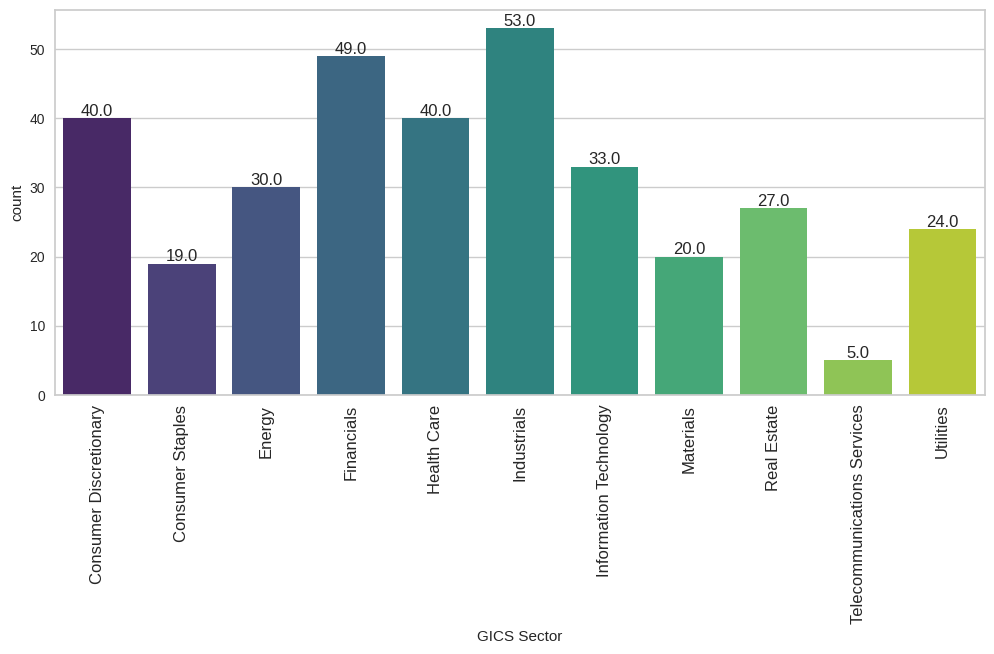

In [ ]:
labeled_barplot(df2, 'GICS Sector')

The stocks are drawn across 11 different sectors with Industrials, Financials, Healthcare, Consumer Discretionary and Information Technology being the most frequent

In [ ]:
df2["GICS Sector"].value_counts(normalize=True)*100

Industrials                   15.59
Financials                    14.41
Consumer Discretionary        11.76
Health Care                   11.76
Information Technology         9.71
Energy                         8.82
Real Estate                    7.94
Utilities                      7.06
Materials                      5.88
Consumer Staples               5.59
Telecommunications Services    1.47
Name: GICS Sector, dtype: float64

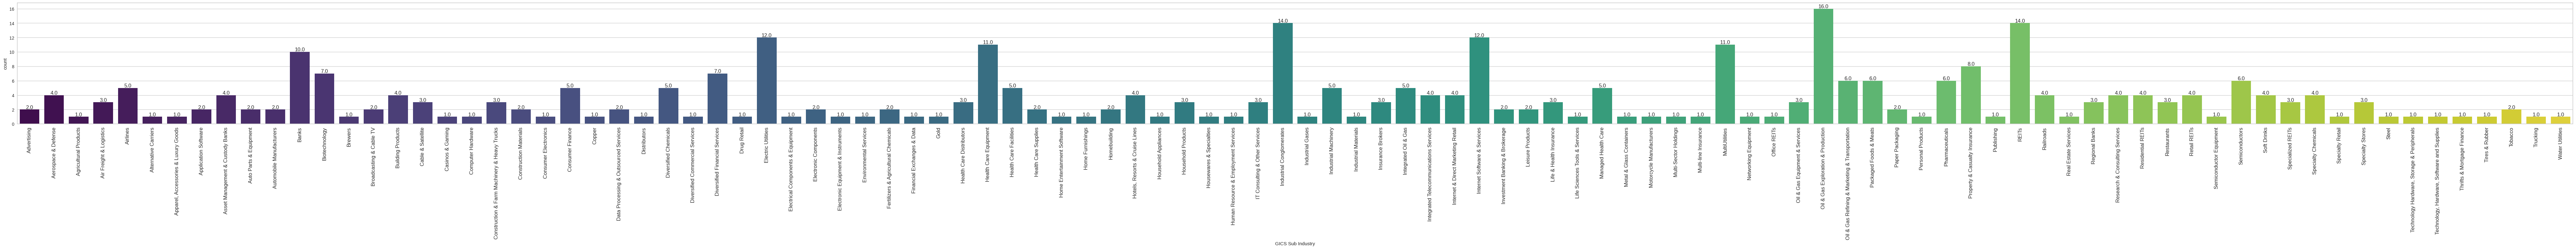

In [ ]:
labeled_barplot(df2, 'GICS Sub Industry')

There are 104 different subindustries across the dataset covering the 340 stocks held. This shows that the dataset is well diversified across the sectors and subindustries

In [ ]:
df2["GICS Sub Industry"].value_counts(normalize=True).head()

Oil & Gas Exploration & Production   0.05
REITs                                0.04
Industrial Conglomerates             0.04
Internet Software & Services         0.04
Electric Utilities                   0.04
Name: GICS Sub Industry, dtype: float64

We observe that the highest industries hold no more than 5% of the stocks in the overall dataset.

In [ ]:
df2.describe()

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio
count,340.00,340.00,340.00,340.00,340.00,340.00,340.00,340.00,340.00,340.00,340.00
mean,80.86,4.08,1.53,39.60,70.02,55537620.59,1494384602.94,2.78,577028337.75,32.61,-1.72
std,98.06,12.01,0.59,96.55,90.42,1946365312.18,3940150279.33,6.59,845849595.42,44.35,13.97
min,4.50,-47.13,0.73,1.00,0.00,-11208000000.00,-23528000000.00,-61.20,27672156.86,2.94,-76.12
25%,38.55,-0.94,1.13,9.75,18.00,-193906500.00,352301250.00,1.56,158848216.10,15.04,-4.35
50%,59.70,4.82,1.39,15.00,47.00,2098000.00,707336000.00,2.90,309675137.80,20.82,-1.07
75%,92.88,10.70,1.70,27.00,99.00,169810750.00,1899000000.00,4.62,573117457.32,31.76,3.92
max,1274.95,55.05,4.58,917.00,958.00,20764000000.00,24442000000.00,50.09,6159292035.00,528.04,129.06


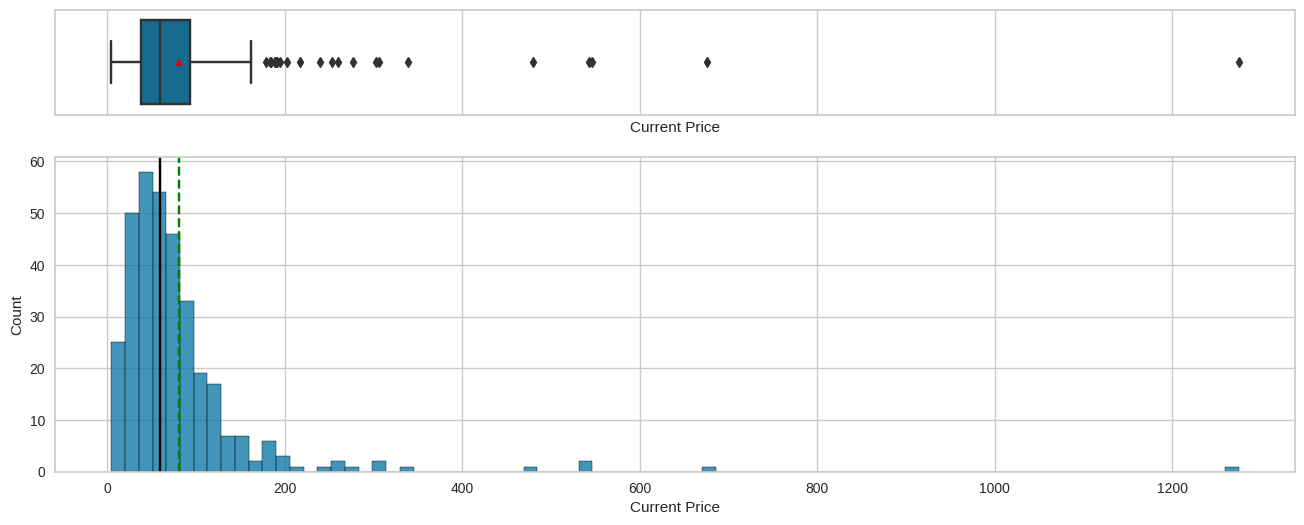

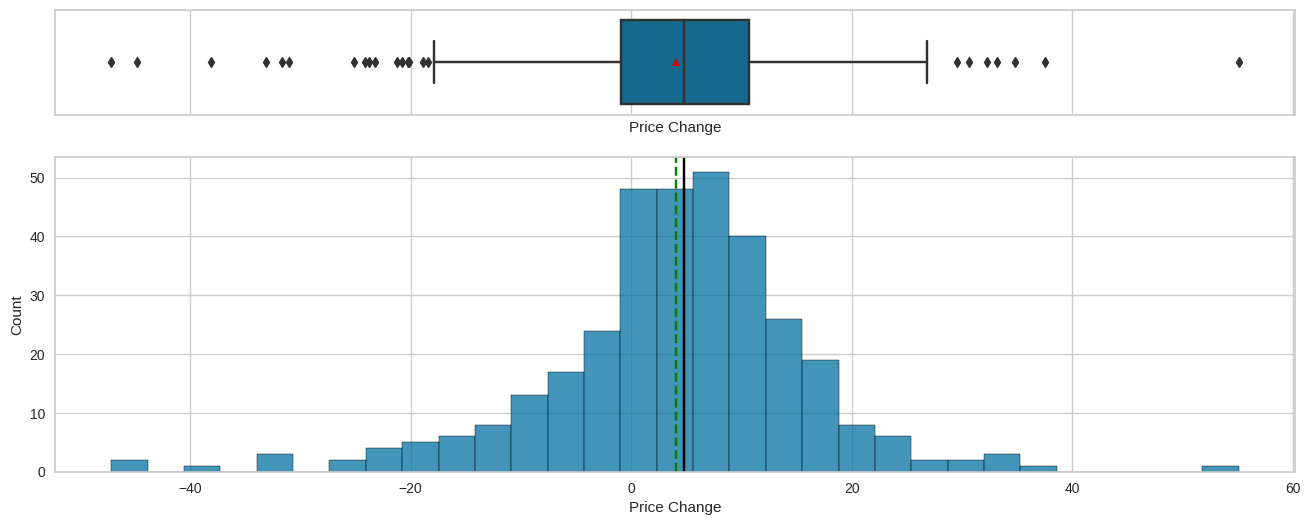

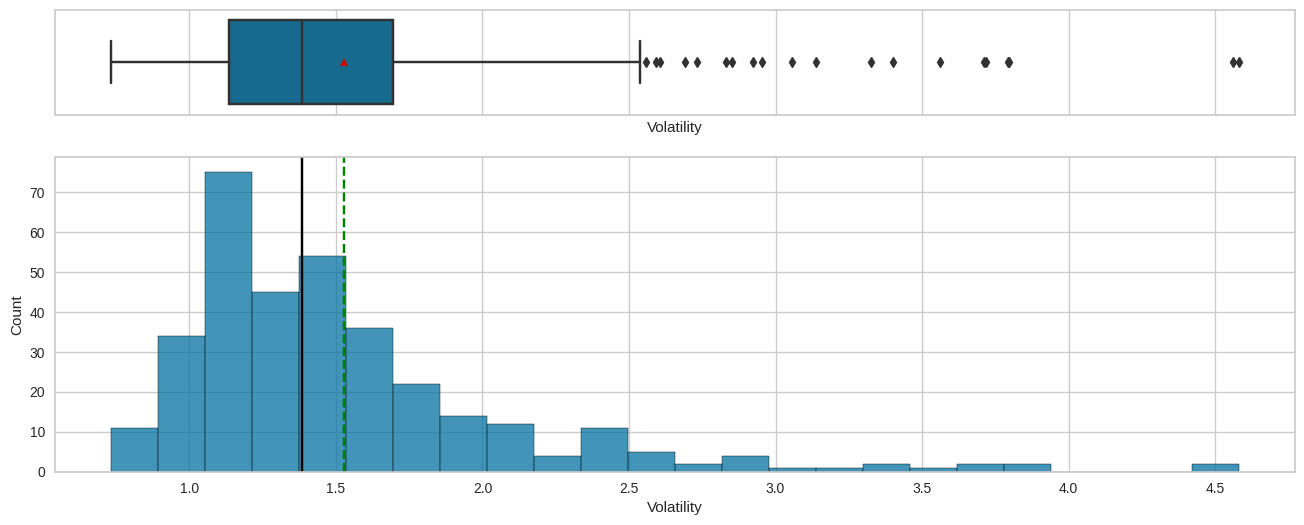

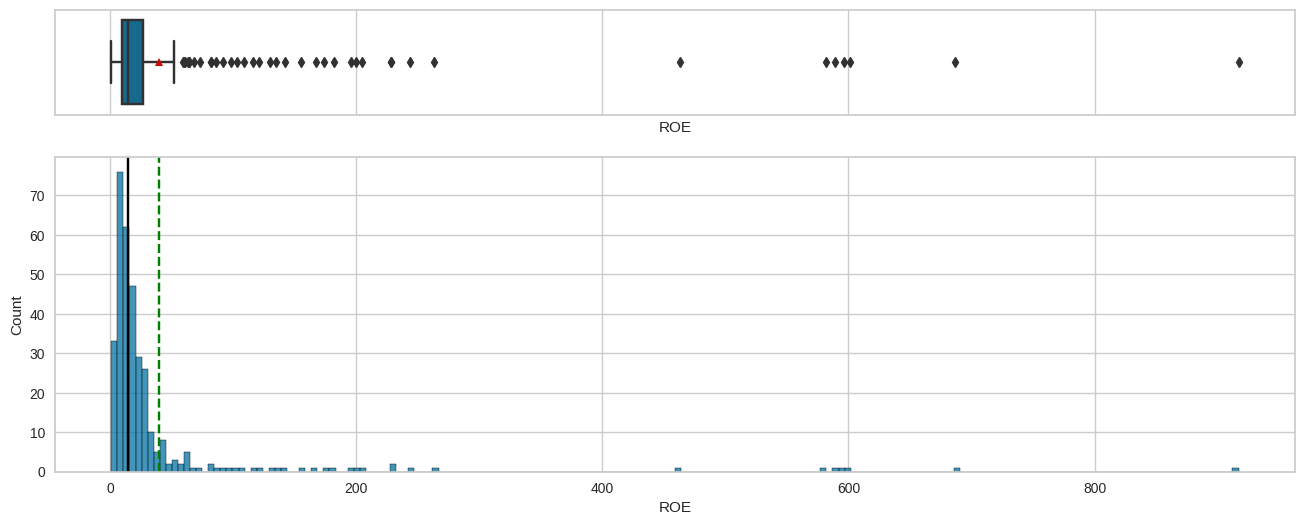

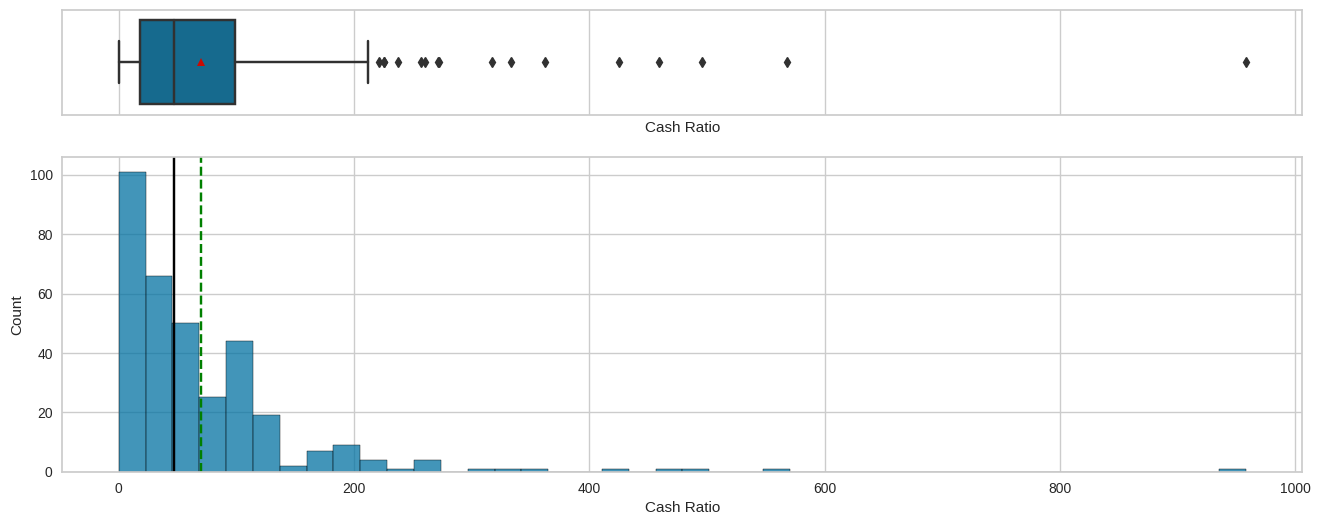

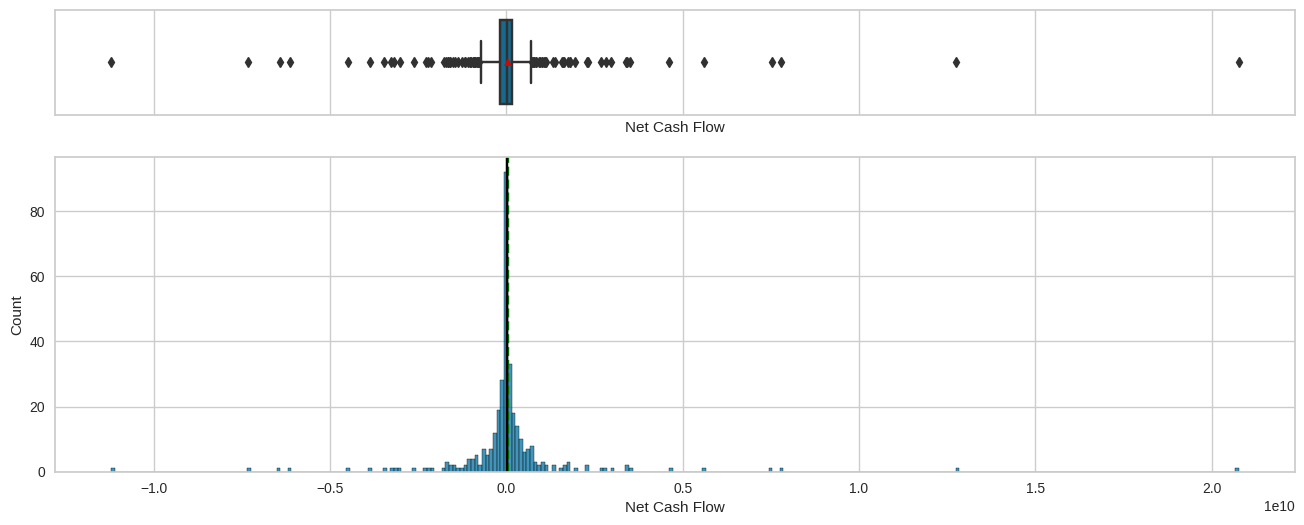

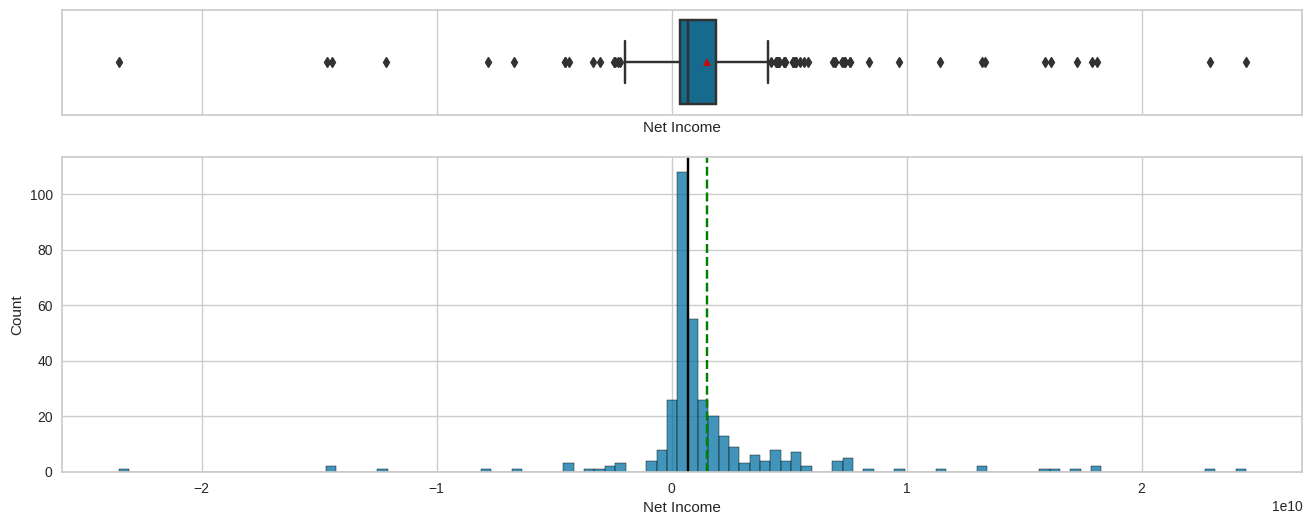

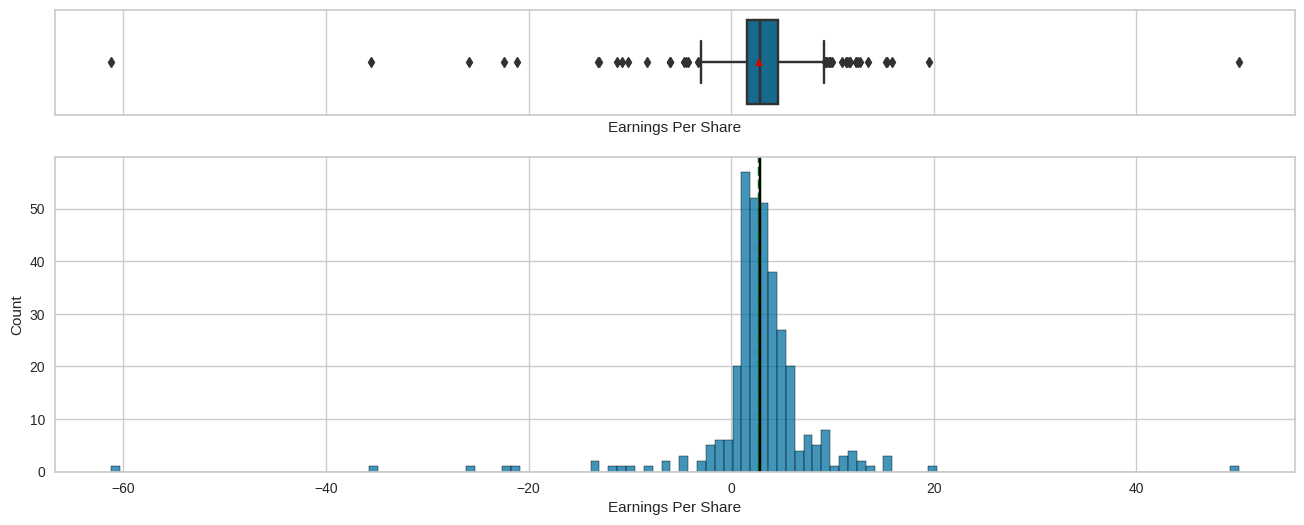

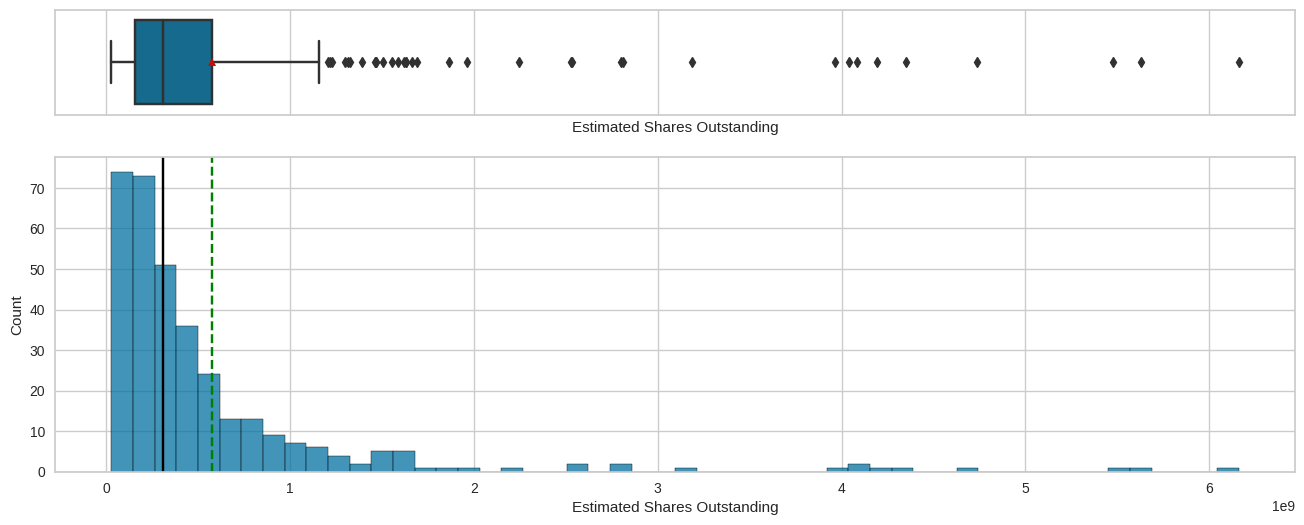

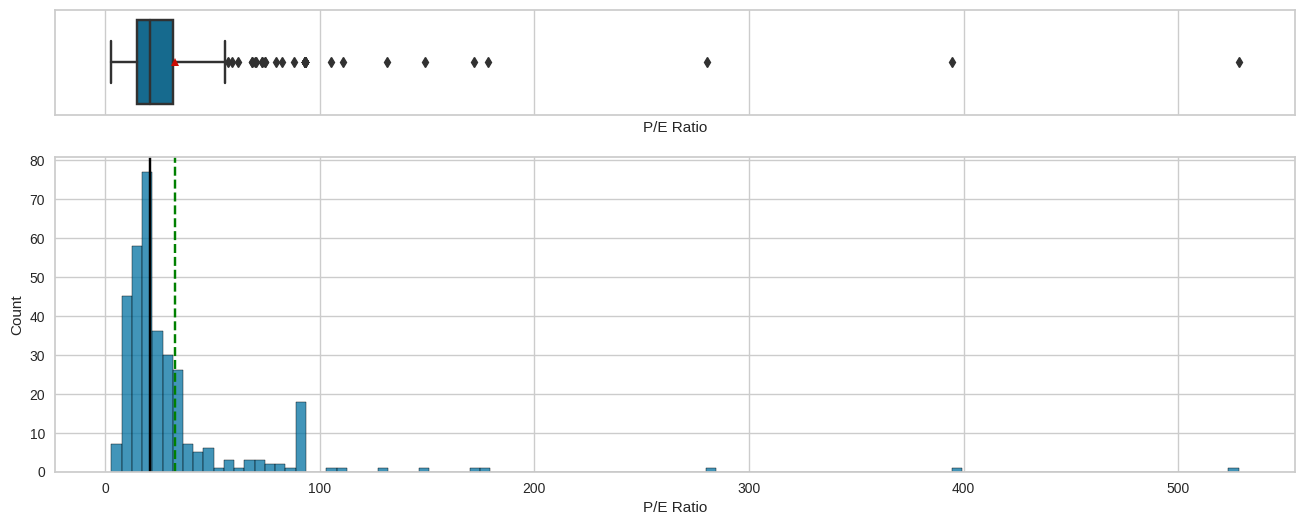

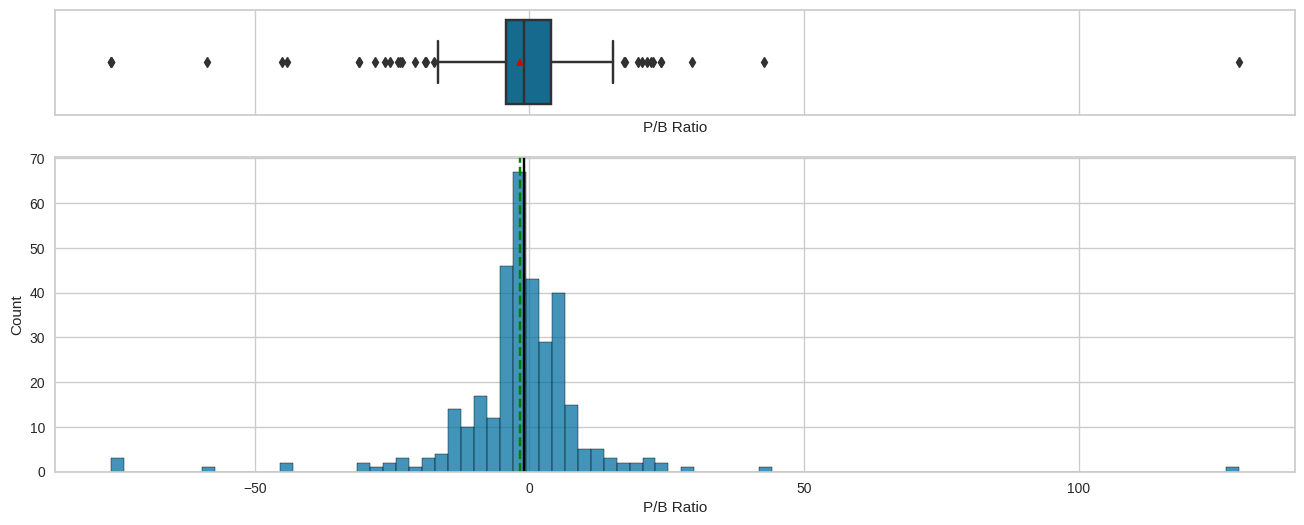

In [ ]:
num_col = df2.select_dtypes(include=np.number).columns.tolist()

#display histograms and boxplots for all numerical columns
for col in num_col:
    histogram_boxplot(df2, col)

The distribution of the current price is normal and right skewed with no stock having a value less than $0
All other variables are normally distributed with varying to no degrees of skewness

In [ ]:
df2.groupby('GICS Sector')['Price Change'].mean().sort_values()

GICS Sector
Energy                        -10.23
Utilities                       0.80
Industrials                     2.83
Financials                      3.87
Materials                       5.59
Consumer Discretionary          5.85
Real Estate                     6.21
Telecommunications Services     6.96
Information Technology          7.22
Consumer Staples                8.68
Health Care                     9.59
Name: Price Change, dtype: float64

The Healthcare sector has shown the highest average price increase over the preceeding period.

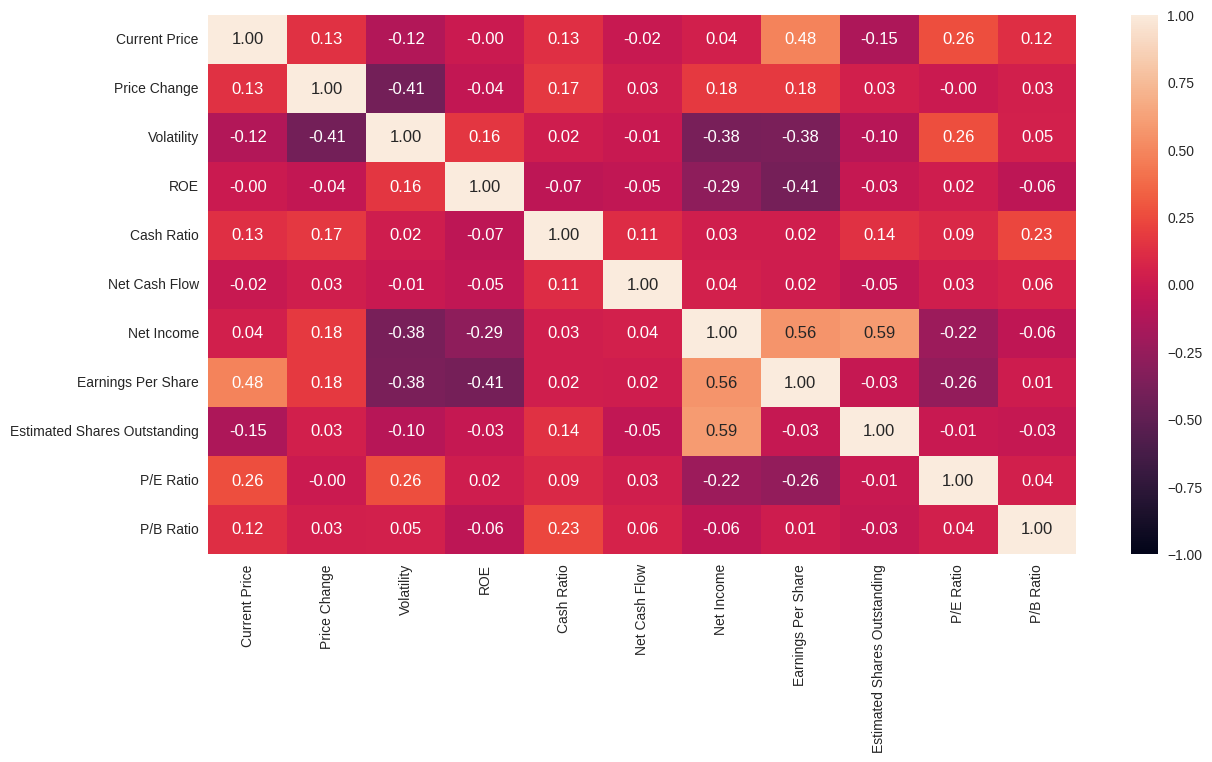

In [ ]:
plt.figure(figsize=(14, 7))
sns.heatmap(
    df2[num_col].corr(),
    annot=True,
    vmin=-1,
    vmax=1,
    fmt=".2f",
  )
plt.show()



*   We see that Net income has the highest correleation with Estimated Shares Outstanding and Earnings Per Share 
*   The lowest correlation occurs between Price Change and Volatility at -0.41



In [ ]:
df2.groupby('GICS Sector')['Cash Ratio'].mean().sort_values(ascending=False)

GICS Sector
Information Technology        149.82
Telecommunications Services   117.00
Health Care                   103.78
Financials                     98.59
Consumer Staples               70.95
Energy                         51.13
Real Estate                    50.11
Consumer Discretionary         49.58
Materials                      41.70
Industrials                    36.19
Utilities                      13.62
Name: Cash Ratio, dtype: float64



*   IT and Telecommunications sectors have the highest cash ratios compared with their pairs.
*   Utilities has the lowest cash ratio, significantly lower than the closest in Industrials which could be due to the level of regulation



In [ ]:
df2.groupby('GICS Sector')['P/E Ratio'].mean().sort_values(ascending=False)

GICS Sector
Energy                        72.90
Information Technology        43.78
Real Estate                   43.07
Health Care                   41.14
Consumer Discretionary        35.21
Consumer Staples              25.52
Materials                     24.59
Utilities                     18.72
Industrials                   18.26
Financials                    16.02
Telecommunications Services   12.22
Name: P/E Ratio, dtype: float64



*   Energy companies have the highest average P/E ratios of all sectors by a considerable margin, with telecoms having the lowest average P/E ratios




## Data Preprocessing

- Duplicate value check
- Missing value treatment
- Outlier check
- Feature engineering (if needed)
- Any other preprocessing steps (if needed)

## EDA

- It is a good idea to explore the data once again after manipulating it.

## K-means Clustering

In [ ]:
scaler = StandardScaler()
subset = df2[num_col].copy()
subset_scaled = scaler.fit_transform(subset)

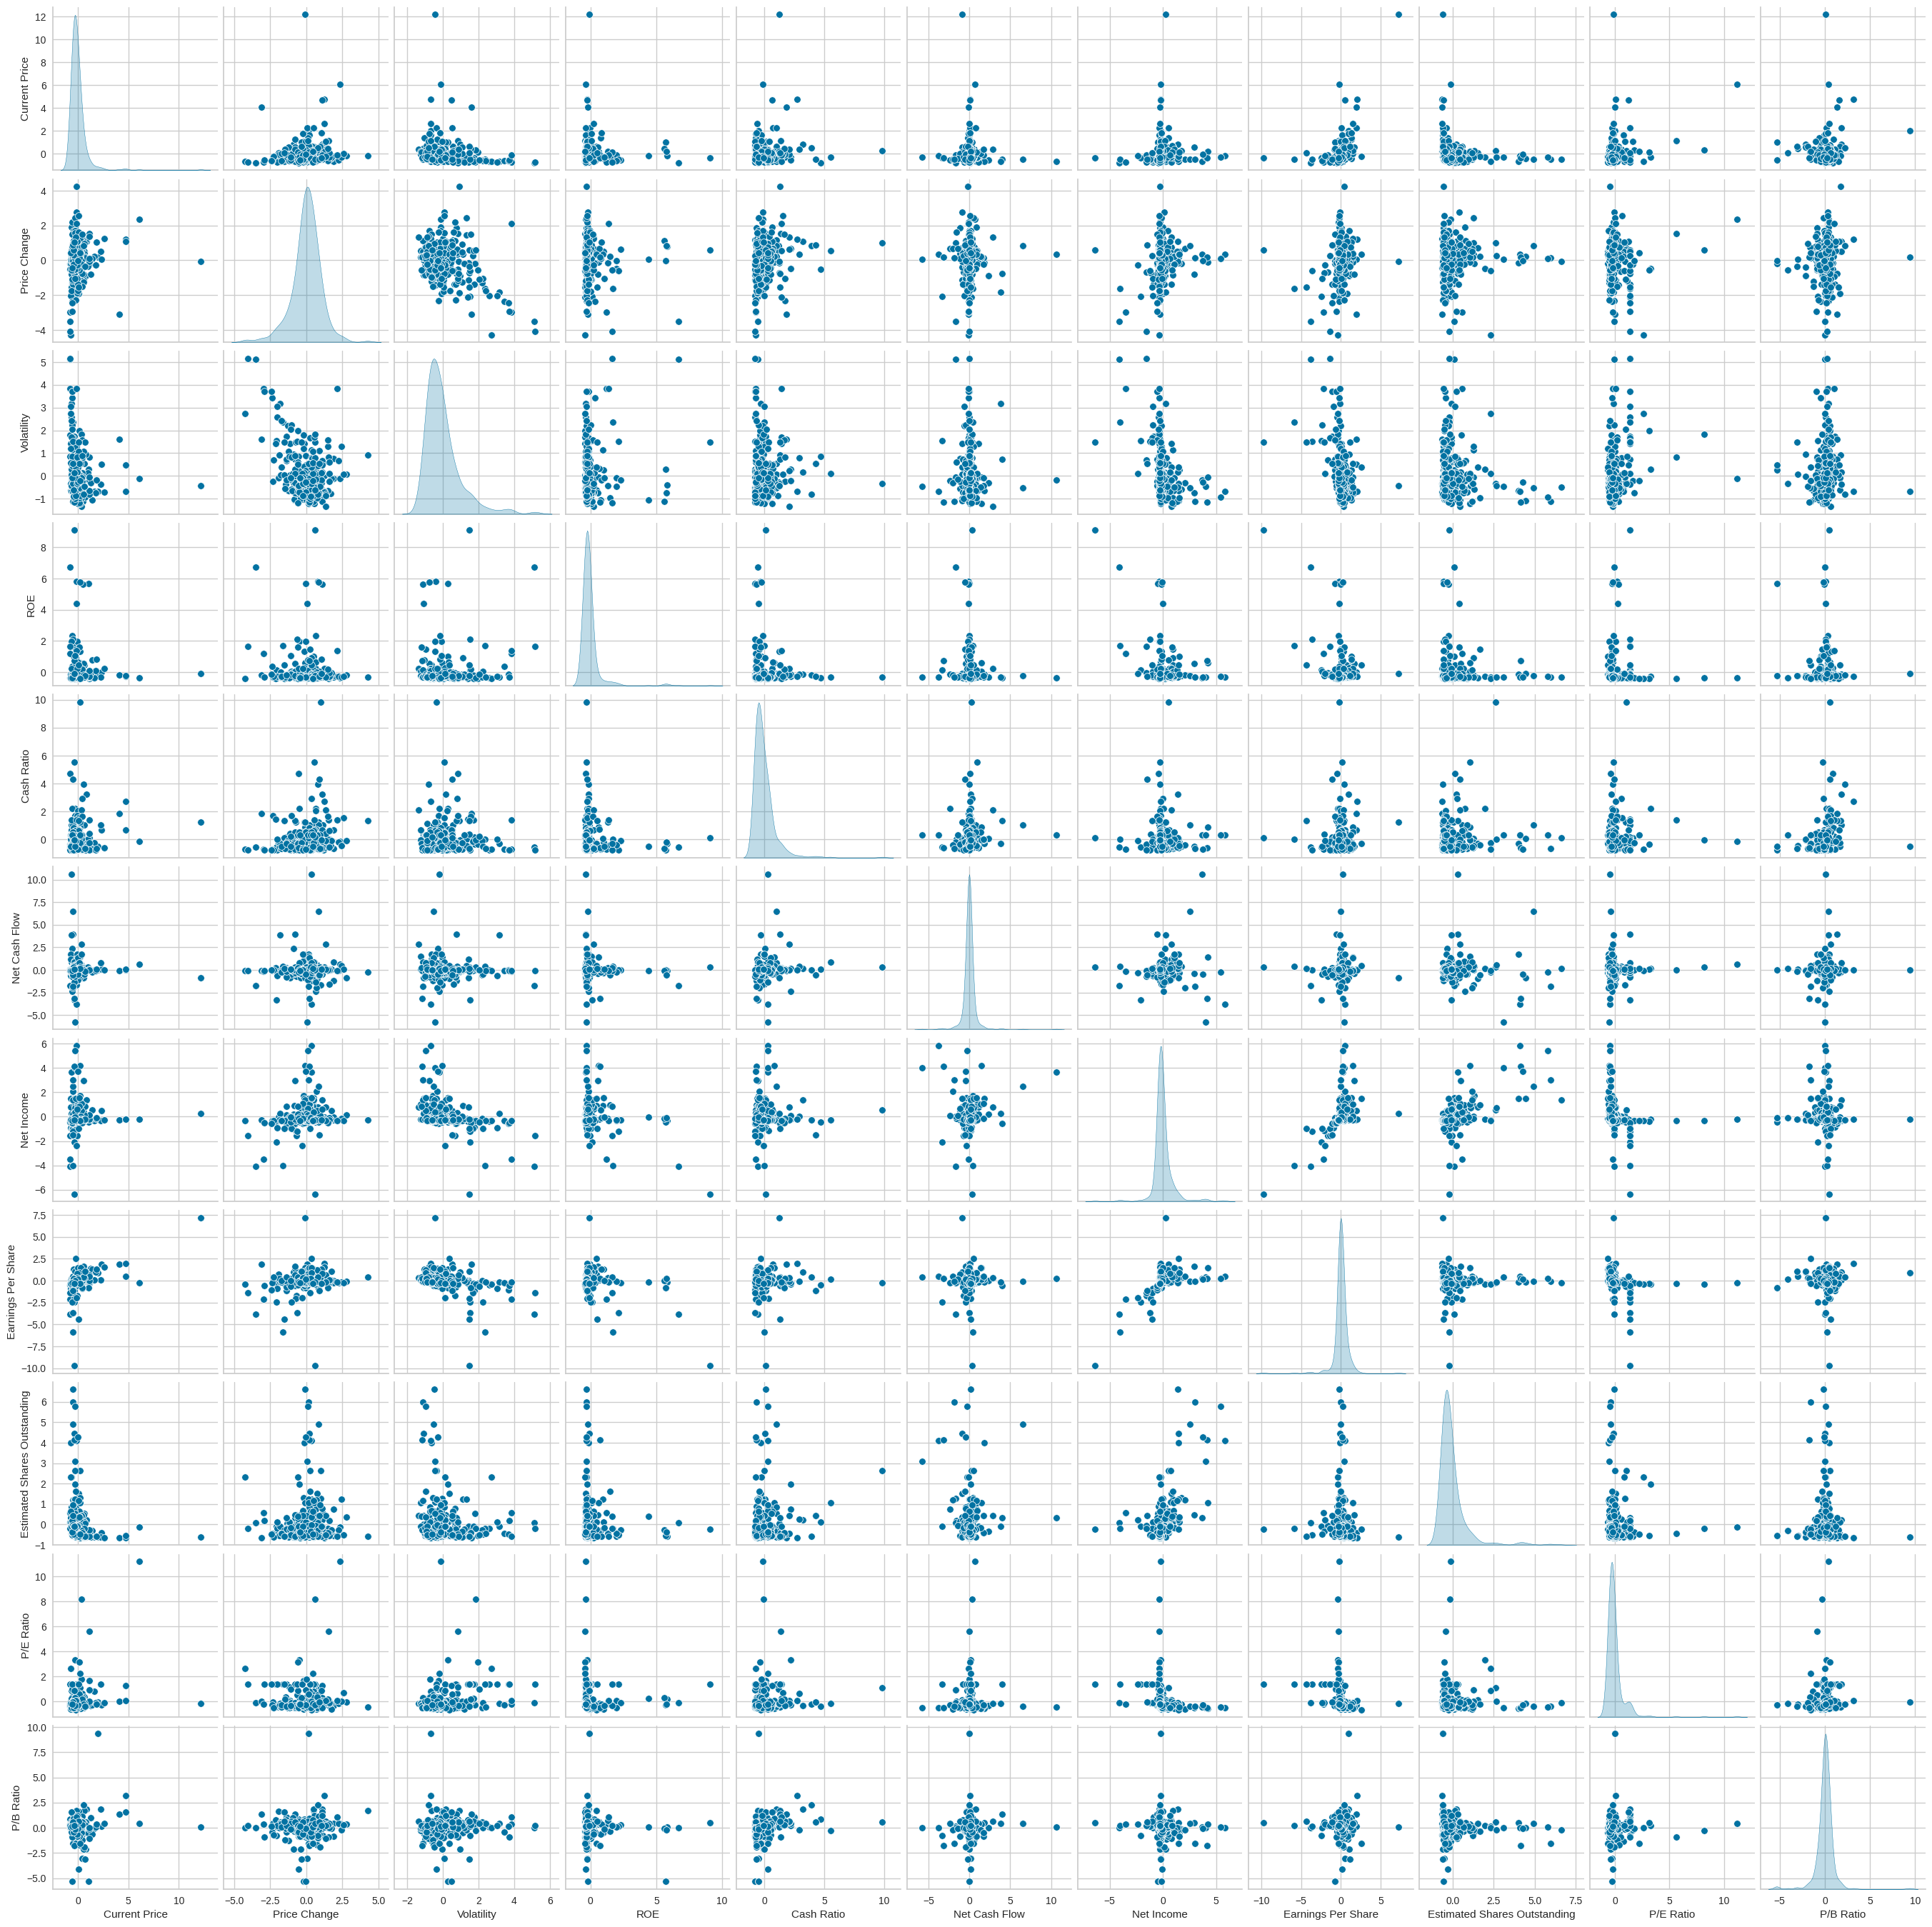

In [ ]:
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)
sns.pairplot(subset_scaled_df, diag_kind='kde')
plt.show()

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

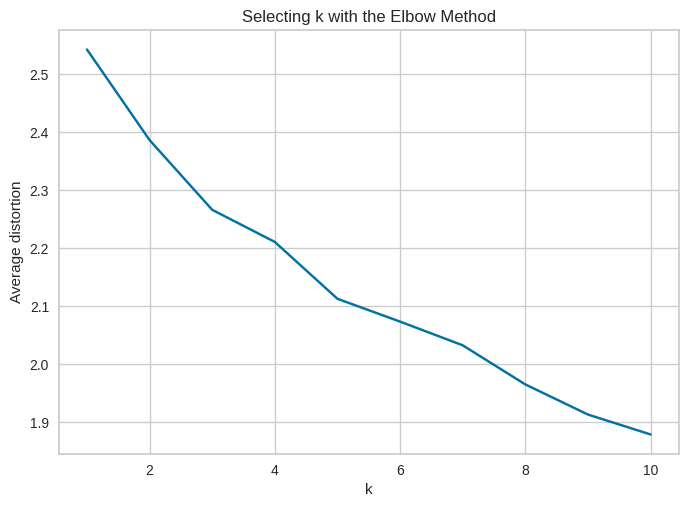

In [ ]:
from scipy.spatial.distance import cdist
clusters=range(1,11)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction=model.predict(subset_scaled_df)
    meanDistortions.append(sum(np.min(cdist(subset_scaled_df, model.cluster_centers_, 'euclidean'), axis=1)) / subset_scaled_df.shape[0])


plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

In [ ]:
 print("Number of Clusters:", k, "\tAverage Distortion:", meanDistortions)

Number of Clusters: 10 	Average Distortion: [2.5425069919221697, 2.3862098789299604, 2.2659465936501304, 2.210521711512746, 2.112457794442205, 2.0731298567598335, 2.0322365597740277, 1.9647827478943696, 1.9128315651110364, 1.878468280255911]


In [ ]:
# Let us first start with K = 3
final_model=KMeans(3)
final_model.fit(subset_scaled_df)
prediction=final_model.predict(subset_scaled_df)

#Append the prediction 
subset_scaled_df["GROUP"] = prediction
subset_scaled_df["GROUP"] = prediction
print("Groups Assigned : \n")
subset_scaled_df.head()

Groups Assigned : 



,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,GROUP
0,-0.39,0.49,0.27,0.99,-0.21,-0.34,1.55,1.31,0.11,-0.65,-0.51,0
1,-0.22,0.36,1.14,0.94,0.08,-0.00,0.93,0.06,1.25,-0.31,-0.50,0
2,-0.37,0.60,-0.43,-0.19,-0.03,0.45,0.74,0.02,1.10,-0.39,0.09,0
3,0.13,0.83,-0.28,-0.32,1.22,-0.15,-0.22,-0.23,-0.09,0.95,0.42,0
4,-0.26,-0.49,0.30,-0.27,2.24,0.13,-0.20,-0.37,1.98,3.29,0.20,1


In [ ]:
subset_scaled_clust = subset_scaled_df.groupby(["GROUP"])
subset_scaled_clust.mean()

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio
GROUP,,,,,,,,,,,
0,0.03,0.12,-0.21,-0.06,-0.04,-0.02,-0.01,0.17,-0.18,-0.18,-0.02
1,-0.17,-1.22,2.15,0.59,0.01,0.05,-1.21,-1.62,-0.06,1.78,0.25
2,-0.29,0.23,-0.59,-0.14,0.78,0.36,3.02,0.15,3.86,-0.27,-0.13


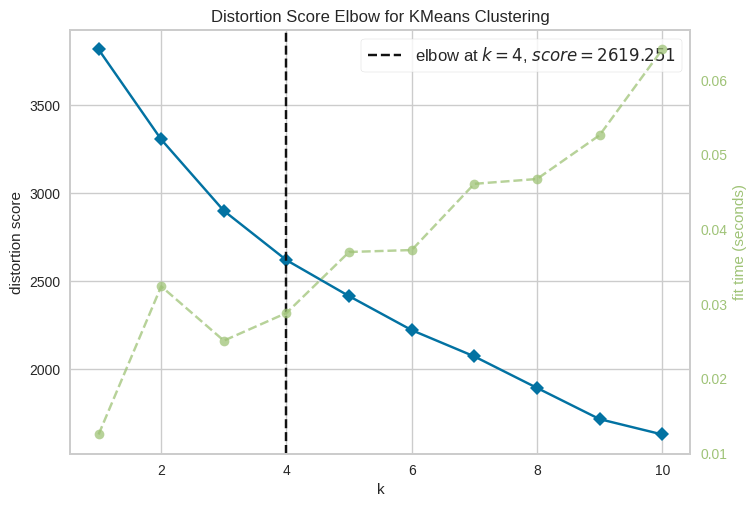

In [ ]:
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(1, 11), timings=True)
visualizer.fit(subset_scaled_df)  # fit the data to the visualizer
visualizer.show()  # finalize and render figure
plt.show()

For n_clusters = 2, the silhouette score is 0.4522020756502662)
For n_clusters = 3, the silhouette score is 0.4723597608786384)
For n_clusters = 4, the silhouette score is 0.4638454180257912)
For n_clusters = 5, the silhouette score is 0.4189463011869303)
For n_clusters = 6, the silhouette score is 0.4064283946029832)
For n_clusters = 7, the silhouette score is 0.415091057870698)
For n_clusters = 8, the silhouette score is 0.4224276482040861)
For n_clusters = 9, the silhouette score is 0.4228173074575485)
For n_clusters = 10, the silhouette score is 0.16933509568988042)


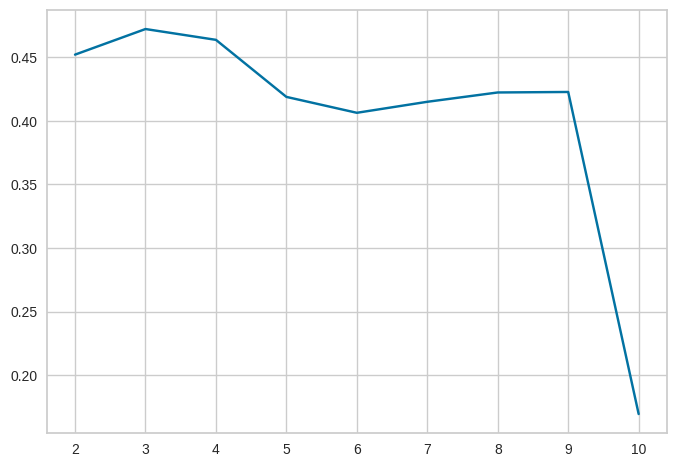

In [ ]:
sil_score = []
cluster_list = range(2, 11)
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    preds = clusterer.fit_predict((subset_scaled_df))
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

#show scores in line graph
plt.plot(cluster_list, sil_score)
plt.show()

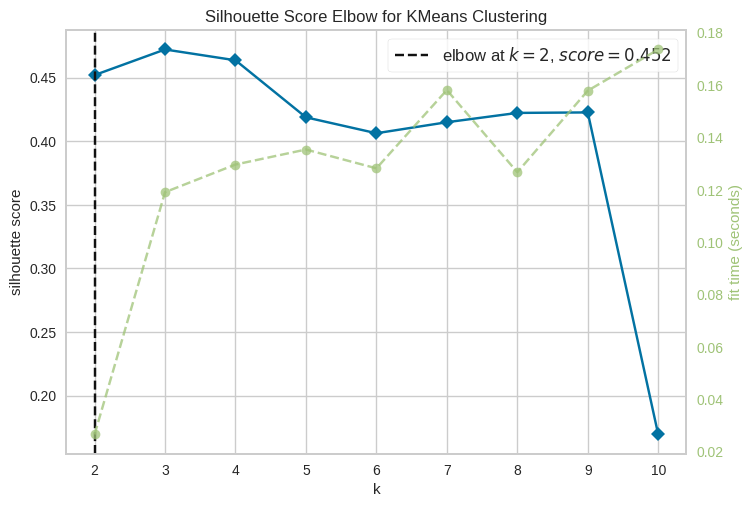

In [ ]:
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2, 11), metric="silhouette", timings=True)
visualizer.fit(subset_scaled_df)  
visualizer.show()  
plt.show()

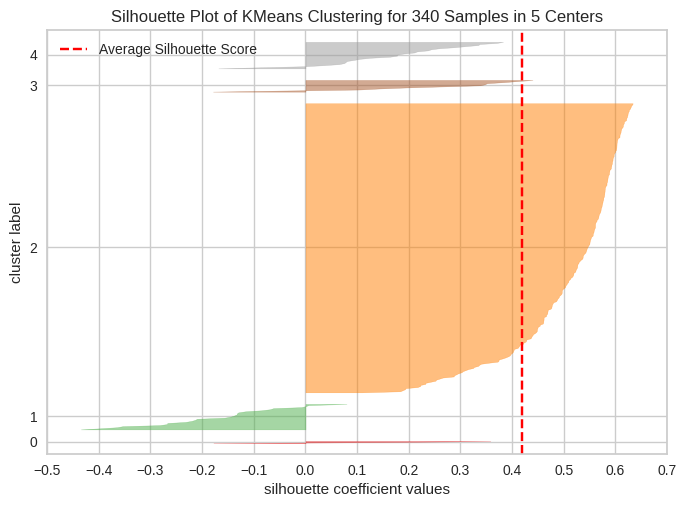

In [ ]:
visualizer = SilhouetteVisualizer(KMeans(5, random_state=42))
visualizer.fit(subset_scaled_df)
visualizer.show()
plt.show()

Based on the plot, it seems the number of clusters with the best performance appears to be 5

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42)

kmeans.fit(subset_scaled_df)

KMeans(n_clusters=5, random_state=42)

In [ ]:
df2["KMeans_clusters"] = kmeans.labels_

cluster_profile = df2.groupby("KMeans_clusters").mean()

#add counts for number of stocks in each cluster
cluster_profile["Count"] = (
    df2.groupby("KMeans_clusters")["Current Price"].count().values
)

In [ ]:
cluster_profile.style.highlight_max(color="yellow", axis=0)

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,Count
KMeans_clusters,,,,,,,,,,,,
0,26.990000,-14.060688,3.296307,603.000000,57.333333,-585000000.000000,-17555666666.666668,-39.726667,481910081.666667,71.528835,1.638633,3
1,234.170932,13.400685,1.729989,25.600000,277.640000,1554926560.000000,1572611680.000000,6.045200,578316318.948800,74.960824,14.402452,25
2,72.810963,5.173140,1.381111,34.916058,53.076642,-14136875.912409,1477862890.510949,3.643668,429299458.750401,23.645335,-3.392014,274
3,50.709167,5.854572,1.142737,29.333333,75.416667,-892666666.666667,13967166666.666666,3.940000,4174873776.750000,16.355810,-4.529687,12
4,38.432308,-15.151704,2.829079,42.115385,47.961538,-140379576.923077,-1965306115.384615,-5.135769,483056138.424615,89.406656,1.330235,26


The highlights show us the highest values under each of the variables according in line with the 5 clusters created. 

*   Cluster 1 shows the highest values for current price, price change, cash ratio, net cashflow, earnings per share and P/B ratio.
*   Cluster 2 has the highest collection of stocks but has no max value on any of the variables



In [ ]:
for k in range(0,df2['KMeans_clusters'].nunique()):
    print('The number of stocks within each GICS Sector for Cluster '+str(k)+' are:')
    print(df2[df2['KMeans_clusters']==k]['GICS Sector'].value_counts())
    print("   ")

The number of stocks within each GICS Sector for Cluster 0 are:
Energy                         3
Consumer Discretionary         0
Consumer Staples               0
Financials                     0
Health Care                    0
Industrials                    0
Information Technology         0
Materials                      0
Real Estate                    0
Telecommunications Services    0
Utilities                      0
Name: GICS Sector, dtype: int64
   
The number of stocks within each GICS Sector for Cluster 1 are:
Health Care                    9
Consumer Discretionary         6
Information Technology         5
Consumer Staples               1
Energy                         1
Financials                     1
Real Estate                    1
Telecommunications Services    1
Industrials                    0
Materials                      0
Utilities                      0
Name: GICS Sector, dtype: int64
   
The number of stocks within each GICS Sector for Cluster 2 are:
Industrial



*   Cluster 0 - Lowest amount of stocks, all 3 come from the energy sector. This cluster also has the highest volatility and generally poor returns as we have negative incomes and earnings per share.
*   Cluster 1 - 25 stocks mostly comprised of the Healthcare, Consumer Discretionary and IT sectors. Mostly profitable cluster with the highest cash ratios and cashflow
*   Cluster 2 - 274 stocks across multiple sectors. Diversified stocks with majority (80%) of the portfolio in this cluster
*   Cluster 3 - This cluster has the highest Net income, covering stocks in the Financial, Healthcare and Telecommunications sectors. These stocks could be profitable to own and have the lowest P/E ratio
*   Cluster 4 - This cluster has the highest P/E ratio with the majority of the stocks coming from the Energy sector. Also one of the cheapest clusters in terms of current price but with a high ROE.





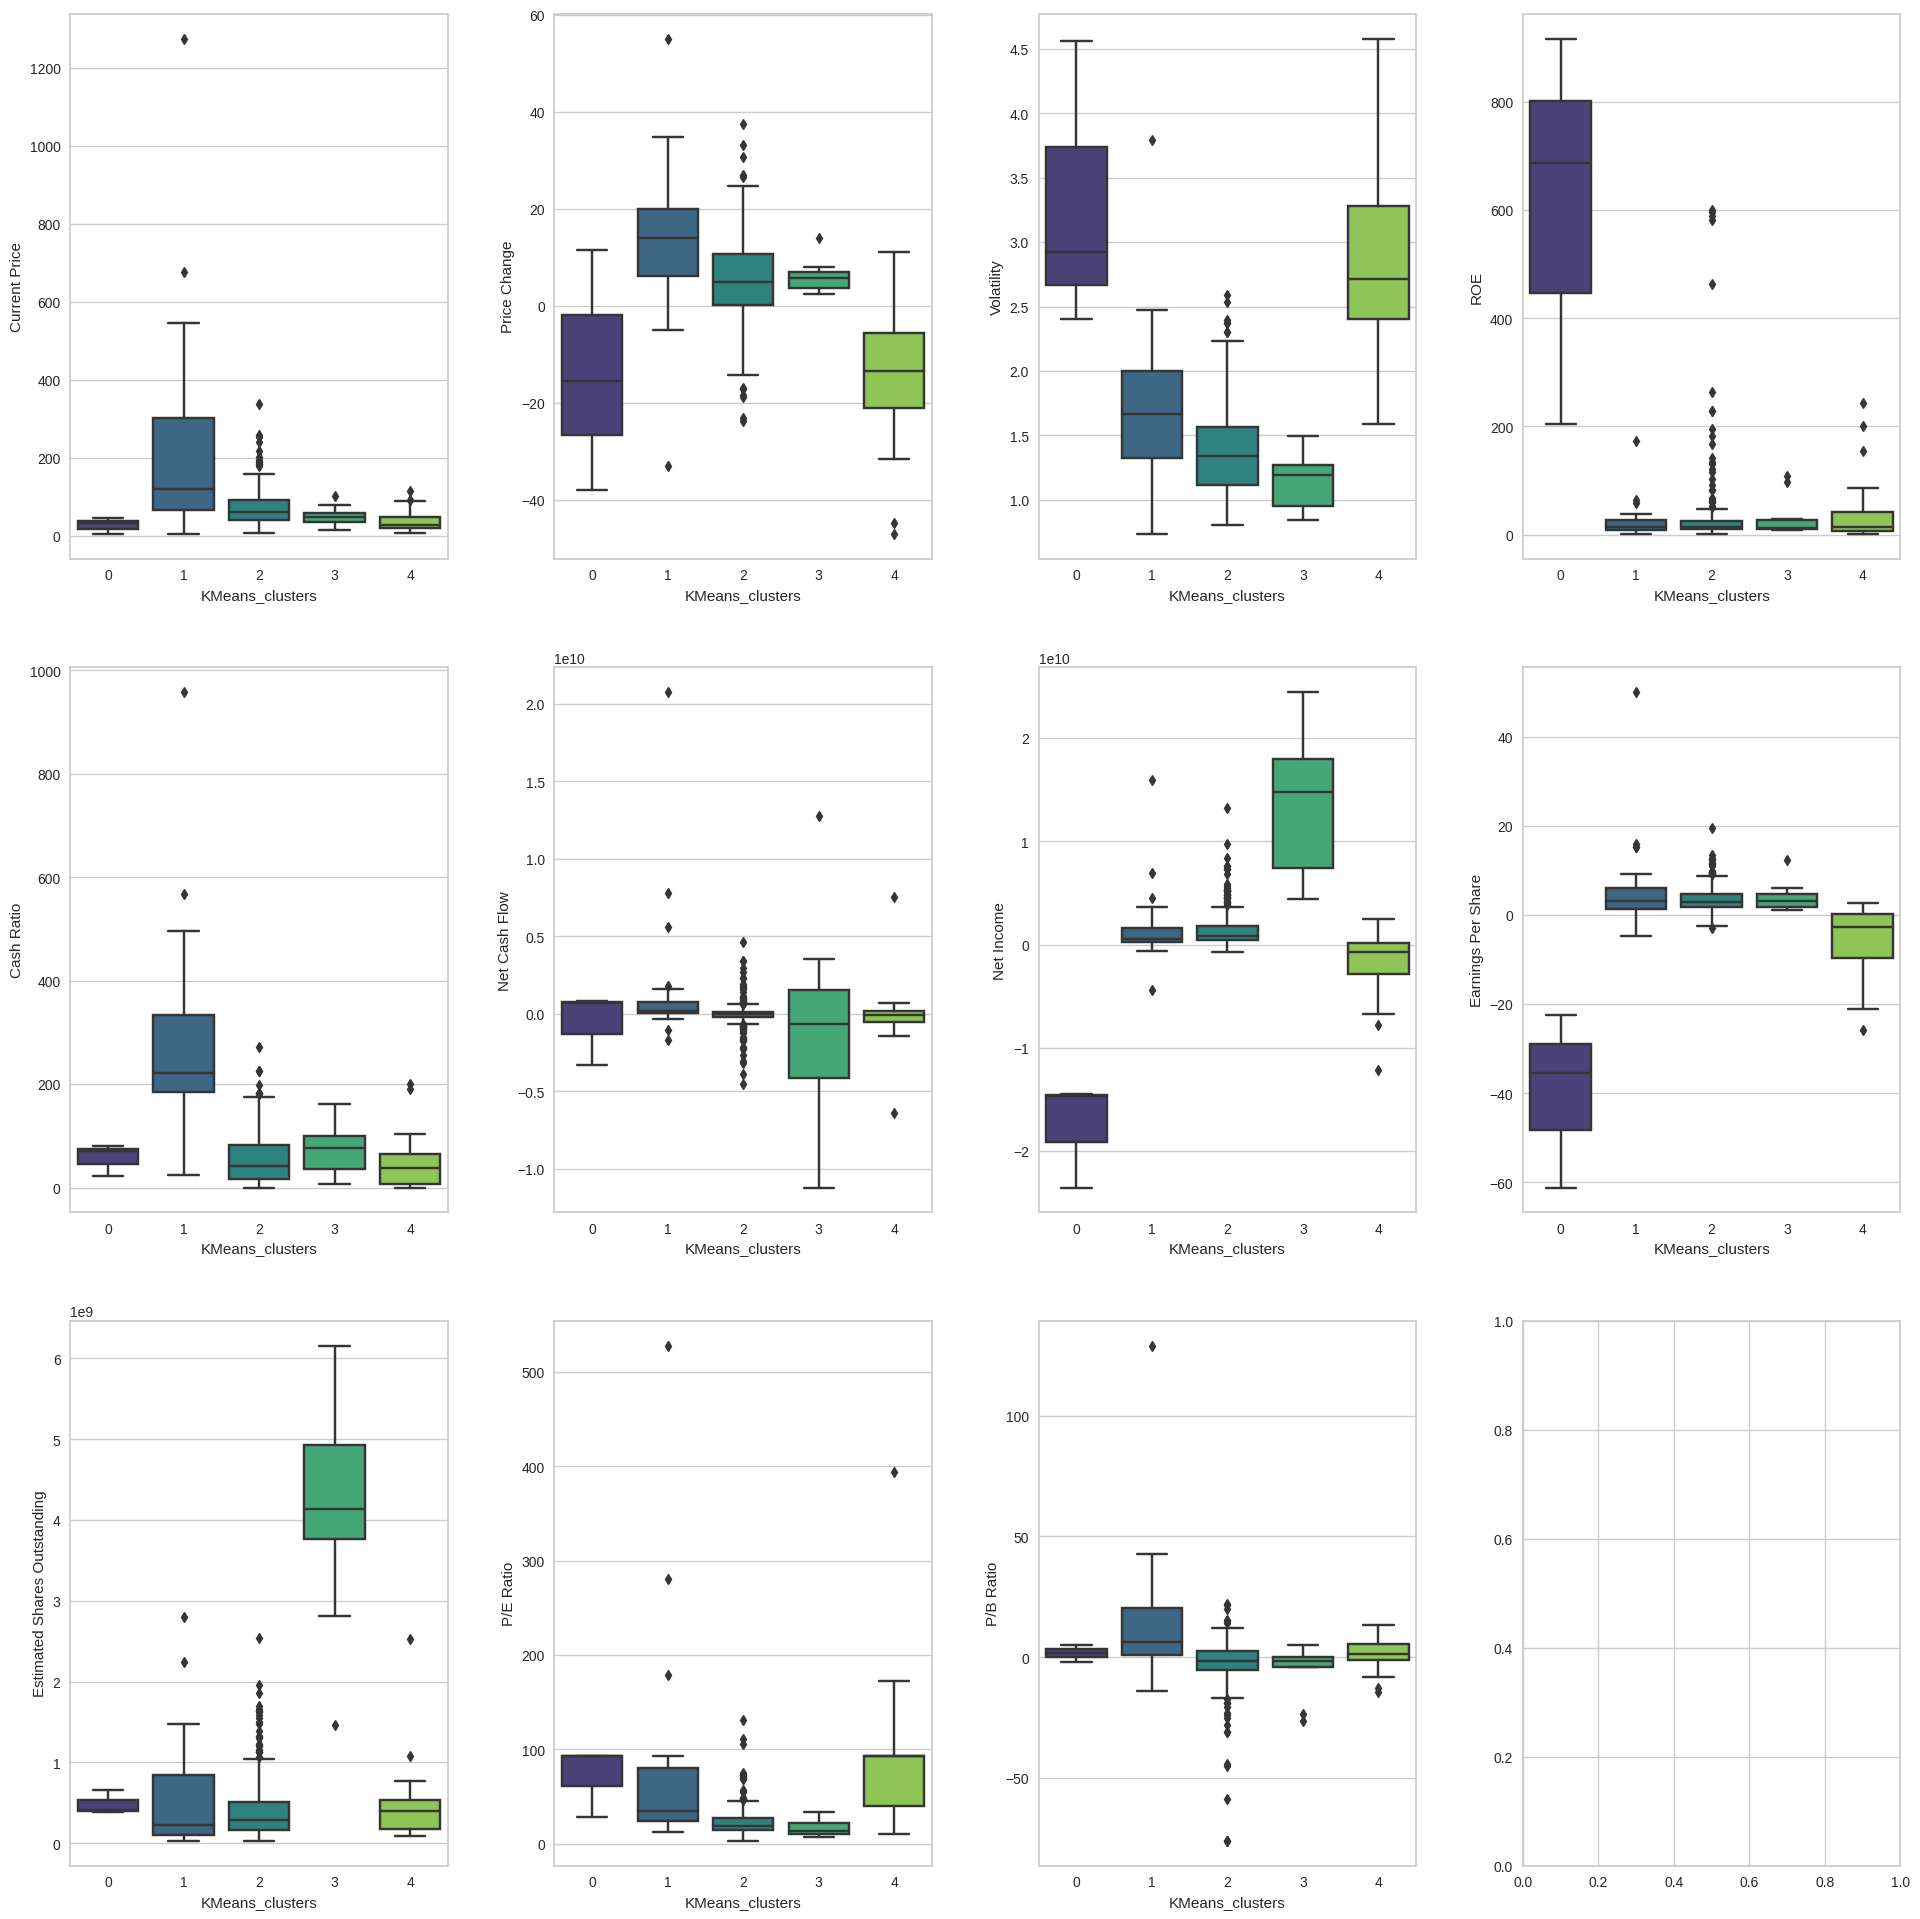

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(20, 20))
counter = 0

for ii in range(3):
    for jj in range(4):
        if counter < 11:
            sns.boxplot(
                ax=axes[ii][jj],
                data=df2,
                y=df2.columns[3+counter],
                x="KMeans_clusters",
                palette="viridis"
            )
            counter = counter + 1

fig.tight_layout(pad=3.0)

## Hierarchical Clustering

In [ ]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, round(c,4)
            )
        )
        print(" ")
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.922.
 
Cophenetic correlation for Euclidean distance and complete linkage is 0.7696.
 
Cophenetic correlation for Euclidean distance and average linkage is 0.9397.
 
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8608.
 
Cophenetic correlation for Chebyshev distance and single linkage is 0.9085.
 
Cophenetic correlation for Chebyshev distance and complete linkage is 0.7997.
 
Cophenetic correlation for Chebyshev distance and average linkage is 0.9309.
 
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8991.
 
Cophenetic correlation for Mahalanobis distance and single linkage is 0.9267.
 
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.8055.
 
Cophenetic correlation for Mahalanobis distance and average linkage is 0.9285.
 
Cophenetic correlation for Mahalanobis distance and weighted linkage is 0.875.
 
Cophenetic correlation for Cityblock distan

In [ ]:
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        round(high_cophenet_corr,4), high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.9397, which is obtained with Euclidean distance and average linkage.


In [ ]:
# list of linkage methods for euclidean distance metric
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(subset_scaled_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
    print(
            "Cophenetic correlation for Euclidean distance and {} linkage is {}.".format(
                lm, round(c,4)
            )
        )
    print(" ")
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.922.
 
Cophenetic correlation for Euclidean distance and complete linkage is 0.7696.
 
Cophenetic correlation for Euclidean distance and average linkage is 0.9397.
 
Cophenetic correlation for Euclidean distance and centroid linkage is 0.9383.
 
Cophenetic correlation for Euclidean distance and ward linkage is 0.7234.
 
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8608.
 


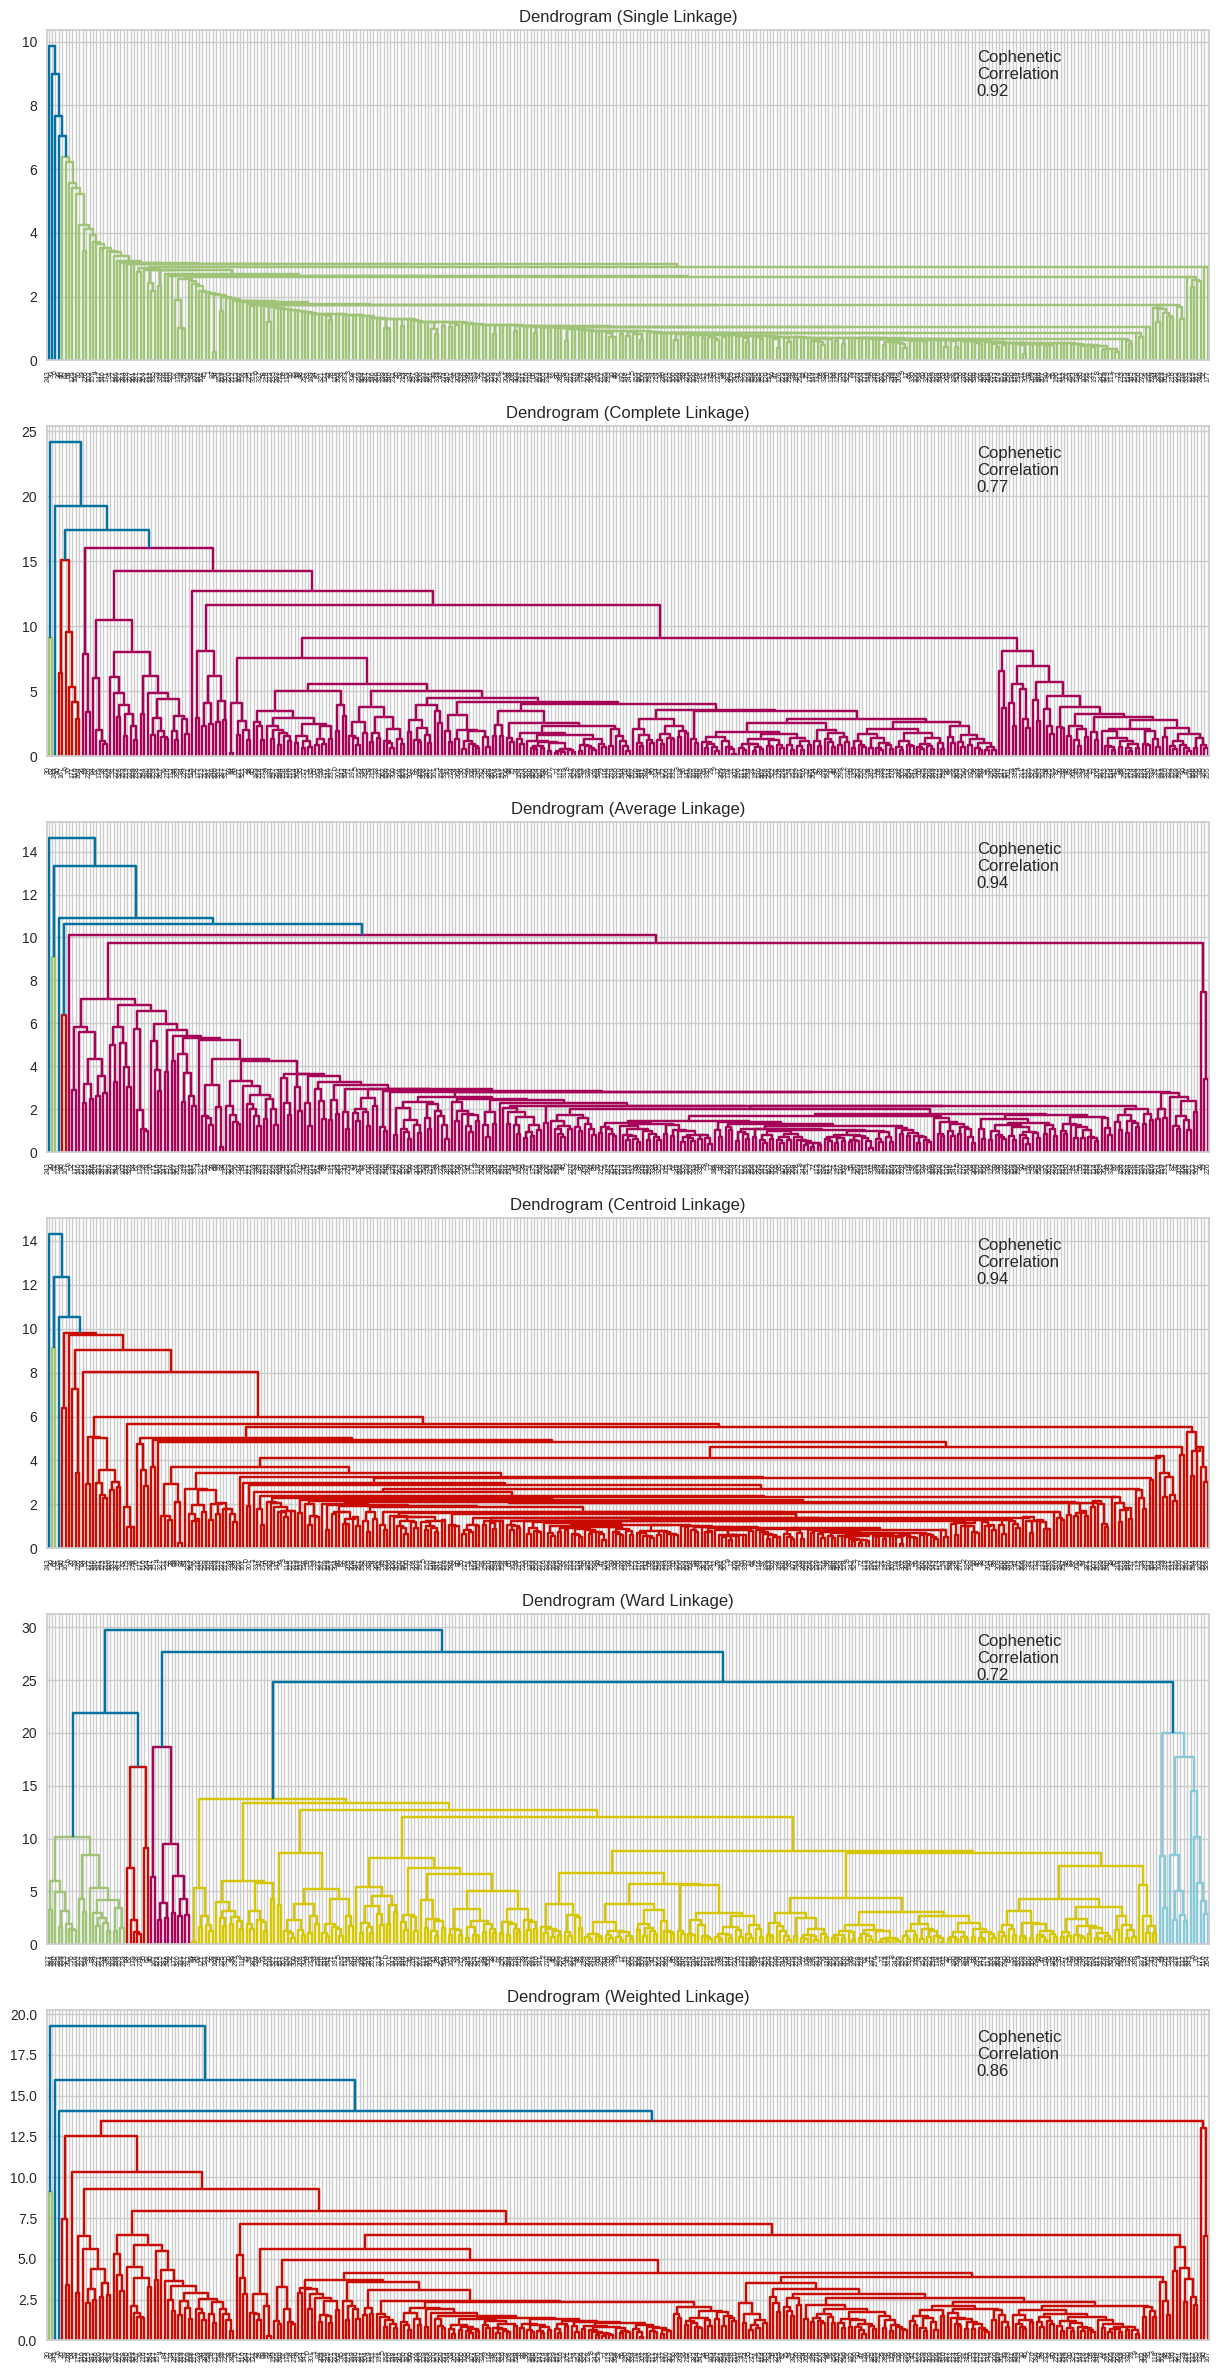

In [ ]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

In [ ]:
Z = linkage(subset_scaled_df, metric='euclidean', method='average')
c, coph_dists = cophenet(Z , pdist(subset_scaled_df))

In [ ]:
hierarchy = AgglomerativeClustering(n_clusters=5, affinity='euclidean',  linkage='average')
hierarchy.fit(subset_scaled_df)

AgglomerativeClustering(affinity='euclidean', linkage='average', n_clusters=5)

In [ ]:
df_hierarchy = df2.copy()
df_hierarchy.drop("KMeans_clusters", axis=1, inplace=True)
df_hierarchy['HC_clusters'] = hierarchy.labels_


In [ ]:
#group dataset by Hierarchical clusters
cluster_profile_HC = df_hierarchy.groupby("HC_clusters").mean()

#add counts for number of stocks in each cluster
cluster_profile_HC["Count"] = (
    df_hierarchy.groupby("HC_clusters")["Current Price"].count().values
)

#show dataframe with maximum values for each metric highlighted
cluster_profile_HC.style.highlight_max(color="yellow", axis=0)

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,Count
HC_clusters,,,,,,,,,,,,
0,77.884243,4.105986,1.516865,35.320359,66.775449,-32825817.365269,1535255703.592814,2.903308,559027333.145509,32.437511,-1.781988,334
1,25.640000,11.237908,1.322355,12.500000,130.500000,16755500000.000000,13654000000.000000,3.295000,2791829362.100000,13.649696,1.508484,2
2,24.485001,-13.351992,3.482611,802.000000,51.000000,-1292500000.000000,-19106500000.000000,-41.815000,519573983.250000,60.748608,1.565141,2
3,104.660004,16.224320,1.320606,8.000000,958.000000,592000000.000000,3669000000.000000,1.310000,2800763359.000000,79.893133,5.884467,1
4,1274.949951,3.190527,1.268340,29.000000,184.000000,-1671386000.000000,2551360000.000000,50.090000,50935516.070000,25.453183,-1.052429,1


In [ ]:
for k in range(0,df_hierarchy['HC_clusters'].nunique()):
    print('The number of stocks within each GICS Sector for Cluster '+str(k)+' are:')
    print(df_hierarchy[df_hierarchy['HC_clusters']==k]['GICS Sector'].value_counts())
    print("   ")

The number of stocks within each GICS Sector for Cluster 0 are:
Industrials                    53
Financials                     48
Health Care                    40
Consumer Discretionary         39
Information Technology         31
Energy                         28
Real Estate                    27
Utilities                      24
Materials                      20
Consumer Staples               19
Telecommunications Services     5
Name: GICS Sector, dtype: int64
   
The number of stocks within each GICS Sector for Cluster 1 are:
Financials                     1
Information Technology         1
Consumer Discretionary         0
Consumer Staples               0
Energy                         0
Health Care                    0
Industrials                    0
Materials                      0
Real Estate                    0
Telecommunications Services    0
Utilities                      0
Name: GICS Sector, dtype: int64
   
The number of stocks within each GICS Sector for Cluster 2 are:



*   The initial Hierarchical Clustering seems to have two clusters with only one stock each and two others with two stocks each. Majority of the stocks are grouped in cluster 0
*   This is not really useful and doesn't help with the business problem



In [ ]:
HCmodel = AgglomerativeClustering(n_clusters=5, affinity="euclidean", linkage="ward")
HCmodel.fit(subset_scaled_df)

AgglomerativeClustering(affinity='euclidean', n_clusters=5)

In [ ]:
subset_scaled_df["HC_clusters"] = HCmodel.labels_
df_hierarchy["HC_clusters"] = HCmodel.labels_

In [ ]:
#group dataset by Hierarchical clusters
cluster_profile_h = df_hierarchy.groupby("HC_clusters").mean()

#add counts for number of stocks in each cluster
cluster_profile_h["Count"] = (
    df_hierarchy.groupby("HC_clusters")["Current Price"].count().values
)

#show dataframe with maximum values for each metric highlighted
cluster_profile_h.style.highlight_max(color="lightblue", axis=0)

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,Count
HC_clusters,,,,,,,,,,,,
0,326.198218,10.563242,1.642560,14.400000,309.466667,288850666.666667,864498533.333333,7.785333,544900261.301333,113.095334,19.142151,15
1,84.355716,3.854981,1.827670,633.571429,33.571429,-568400000.000000,-4968157142.857142,-10.841429,398169036.442857,42.284541,-11.589502,7
2,43.679166,6.333860,1.136456,21.666667,71.333333,602333333.333333,13782166666.666666,3.257500,4123307553.766666,16.757853,-4.871141,12
3,73.016410,5.284076,1.422207,25.713781,60.533569,76907862.190813,1532634480.565371,3.669982,438977951.408869,24.734257,-2.665934,283
4,35.736522,-16.097710,2.838163,55.434783,41.043478,-454960608.695652,-3009616130.434783,-7.587826,500804207.297391,82.389602,0.987059,23


In [ ]:
# print the number of stocks in each GICS sector for each cluster
for k in range(0,df_hierarchy['HC_clusters'].nunique()):
    print('The number of stocks within each GICS Sector for Cluster '+str(k)+' are:')
    print(df_hierarchy[df_hierarchy['HC_clusters']==k]['GICS Sector'].value_counts())
    print("   ")

The number of stocks within each GICS Sector for Cluster 0 are:
Health Care                    5
Information Technology         4
Consumer Discretionary         3
Consumer Staples               1
Real Estate                    1
Telecommunications Services    1
Energy                         0
Financials                     0
Industrials                    0
Materials                      0
Utilities                      0
Name: GICS Sector, dtype: int64
   
The number of stocks within each GICS Sector for Cluster 1 are:
Consumer Staples               2
Energy                         2
Consumer Discretionary         1
Financials                     1
Industrials                    1
Health Care                    0
Information Technology         0
Materials                      0
Real Estate                    0
Telecommunications Services    0
Utilities                      0
Name: GICS Sector, dtype: int64
   
The number of stocks within each GICS Sector for Cluster 2 are:
Financials


*   Cluster 0 - 15 stocks mostly of stocks within the Health Care, Information Technology (IT), and Consumer Discretionary sectors. Cluster also experiences the highest cash ratios
*   Cluster 1 - 7 stocks comprising mostly of Consumer Staples and Energy stocks. This cluster shows the highest ROE.
*   Cluster 2 - 12 stocks comprising mostly of Financials, Healthcare and Telecommunications. Companies within this cluster have the highest net income and cashflows
*   Cluster 3 - 283 stocks, approx. 83% of the dataset. The most diversified cluster.
*   Cluster 4 - 22 stocks dominated by the Energy sector. This cluster shows the higest volatility amongst all the clusters






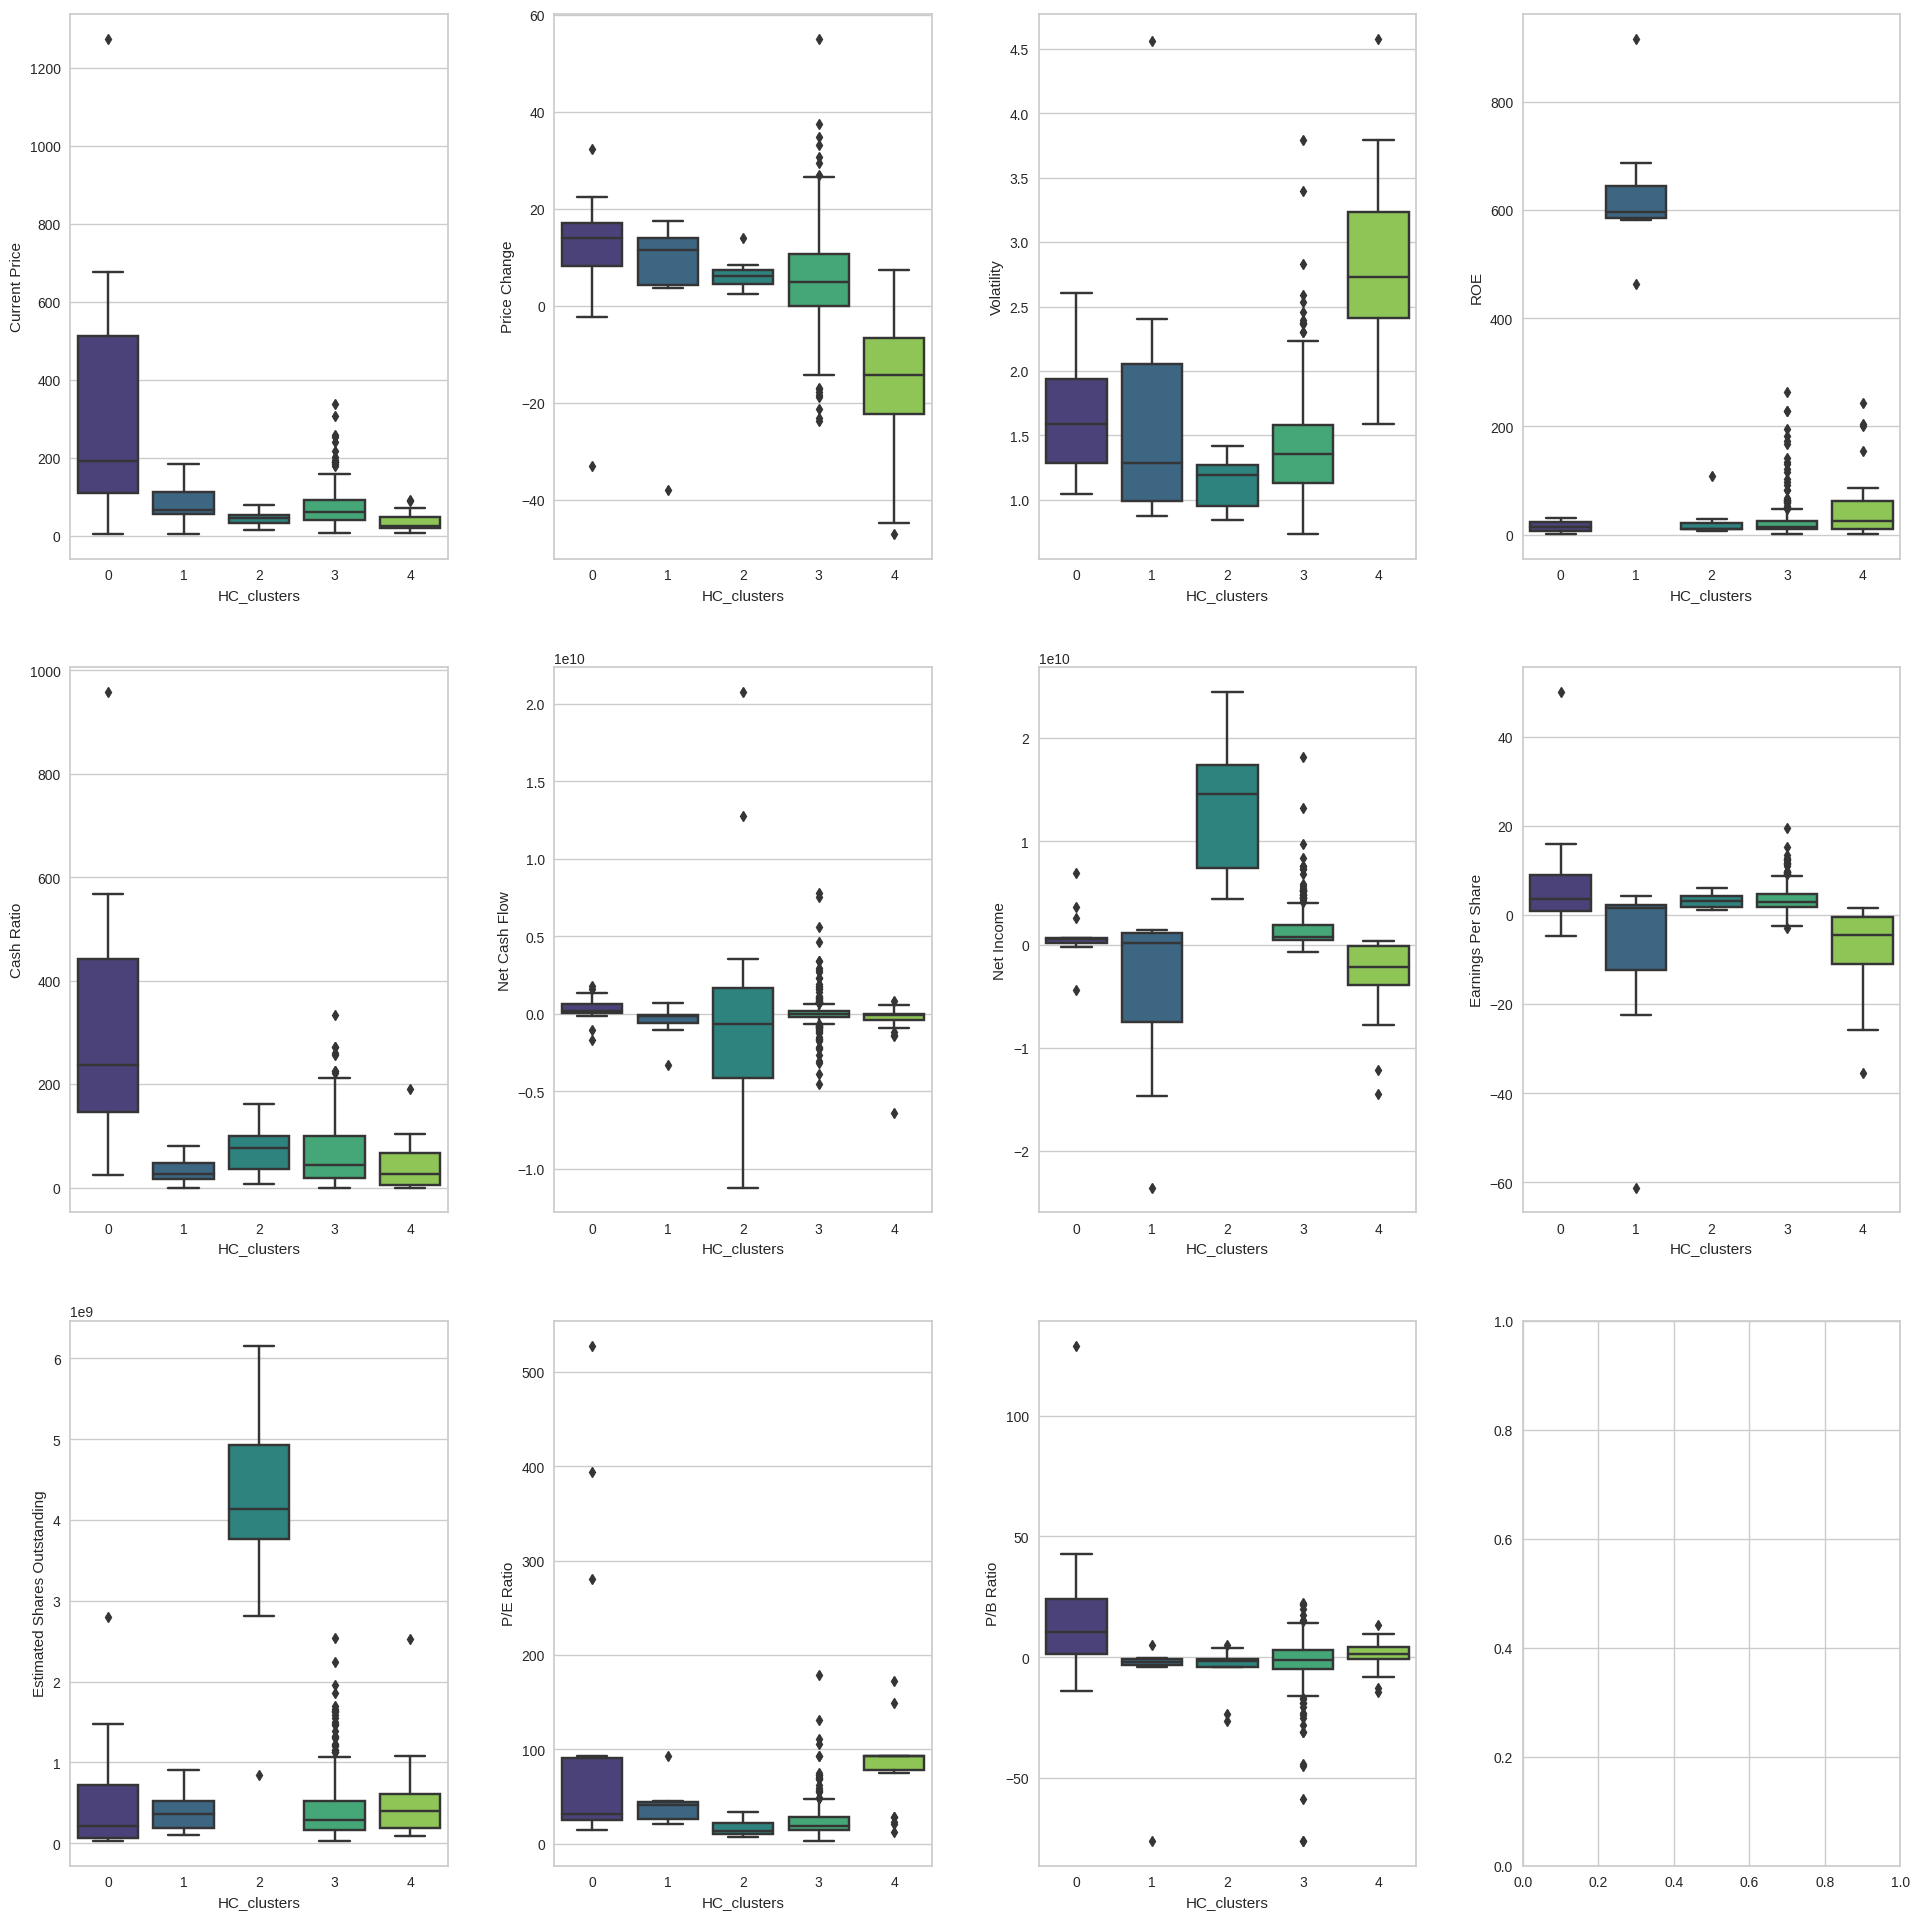

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(20, 20))
counter = 0

for ii in range(3):
    for jj in range(4):
        if counter < 11:
            sns.boxplot(
                ax=axes[ii][jj],
                data=df_hierarchy,
                y=df_hierarchy.columns[3+counter],
                x="HC_clusters",
                palette="viridis"
            )
            counter = counter + 1

fig.tight_layout(pad=3.0)

We get better clustering when we switch to the Ward linkage as shown above. Similar to the Kmeans clustering, the clusters are better spread out across the stocks we have

## K-means vs Hierarchical Clustering

You compare several things, like:
- **Which clustering technique took less time for execution?** - Both Kmeans and Agglomerative clustering fit the dataset within 5s

- **Which clustering technique gave you more distinct clusters, or are they the same?** - Both algorithms give a similar distribution in the grouped clusters
- **How many observations are there in the similar clusters of both algorithms?** - For both algorithms, 5 clusters provides a distinct grouping for the dataset
- **How many clusters are obtained as the appropriate number of clusters from both algorithms?** - Both algorithms yield similar clusters based on the outliers within the 11 variables


## Actionable Insights and Recommendations

*   Trade & Ahead should further identify the financial goals and risk appetites for their clients and recommend a potential portfolio that fits for each client
*   A deeper dive to each of the stocks through financial statement analysis to get better fits for the clients is also recommended
